# Goal
- Plot the GAM plot and see how we can compare to ground truth

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [405]:
import pytorch_lightning as pl
from lib.lightning.airl import AIRLLightning, AIRL_NODEGAM_Lightning
import numpy as np
import pandas as pd
import torch
from lib.sepsis_simulator.sepsisSimDiabetes.State import State
from os.path import join as pjoin, exists as pexists

from lib.vis_utils import vis_main_effects
from lib.lightning.utils import load_best_model_from_trained_dir, load_hparams
from lib.sepsis_simulator.utils import load_mma_model
import pickle
import cvxpy as cvx
from lib.utils import Timer
from lib.mimic3.dataset import HypotensionDataset
from lib.nodegam.utils import bin_data
from lib.utils import average_GAM_dfs
from sklearn.preprocessing import QuantileTransformer, StandardScaler
import matplotlib.patches as patches

import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', None)

# Simulation Gamma=0.9

- Should I use the dataset trained by expert? There might be some centering problems.

In [118]:
from lib.nodegam.utils import extract_GAM, process_in_chunks, check_numpy

## Load expert data

In [119]:
# Load the expert data
with open('./data/sepsisSimData/gamMDP_N5000_g0.9_f0_expert_data.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [120]:
data.keys()

dict_keys(['eps0.07', 'eps0.14', 'optimal', 'optimal_reward_mean', 'optimal_reward_std'])

Why the optimal policy does not get the highest reward?
- Random seed?
- The library solver?

In [121]:
data['optimal_reward_mean'], data['optimal_reward_std']

(-0.8833585802121373, 0.0024822711951873995)

In [122]:
data['optimal']['test_D']['o'].shape

(5000, 20, 5)

In [123]:
all_X = np.concatenate([data['optimal']['train_D']['o'], data['optimal']['test_D']['o']], axis=0)
all_X = all_X.reshape(-1, all_X.shape[-1]) # Reshape from (N, T, D) to (NxT, D)
all_X = pd.DataFrame(all_X.astype(np.float32), columns=['HR', 'SysBP', 'perxoxyg', 'glucose', 'noise'])

In [124]:
# all_next_states = np.empty((State.NUM_FULL_STATES, State.PHI_DIM), dtype=np.float32)

# for i in range(State.NUM_FULL_STATES):
#     all_next_states[i] = State(state_idx=i, idx_type='full')\
#         .get_phi_vector().astype(np.float32)

# all_X = pd.DataFrame(all_next_states, columns=['HR', 'SysBP', 'perxoxyg', 'glucose', 'noise'])
# all_X[:5]

## GAM MDP Ground truth

In [125]:
hr_state_dict = {0: -0.8, 1: 0, 2: -1} # non-linear
sysbp_state_dict = {0: -1.2, 1: 0, 2: -0.6} # non-linear
percoxyg_state = {0: -1, 1: 0} # non-linear
glucose_state_dict = {0: -0.8, 1: -0.4, 2: 0, 3: -0.4, 4: -0.8} # non-linear

In [126]:
def gt_predict_fn(X):
    score = np.zeros(X.shape[0])
    
    for i in range(X.shape[0]):
        score[i] += hr_state_dict[X[i, 0]]
        score[i] += sysbp_state_dict[X[i, 1]]
        score[i] += percoxyg_state[X[i, 2]]        
        score[i] += glucose_state_dict[X[i, 3]]
    return score

In [127]:
gt_df = extract_GAM(all_X, gt_predict_fn)
gt_df

feat_name  feat_idx  \
0    offset        -1   
1        HR         0   
2     SysBP         1   
3  perxoxyg         2   
4   glucose         3   
5     noise         4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     x  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

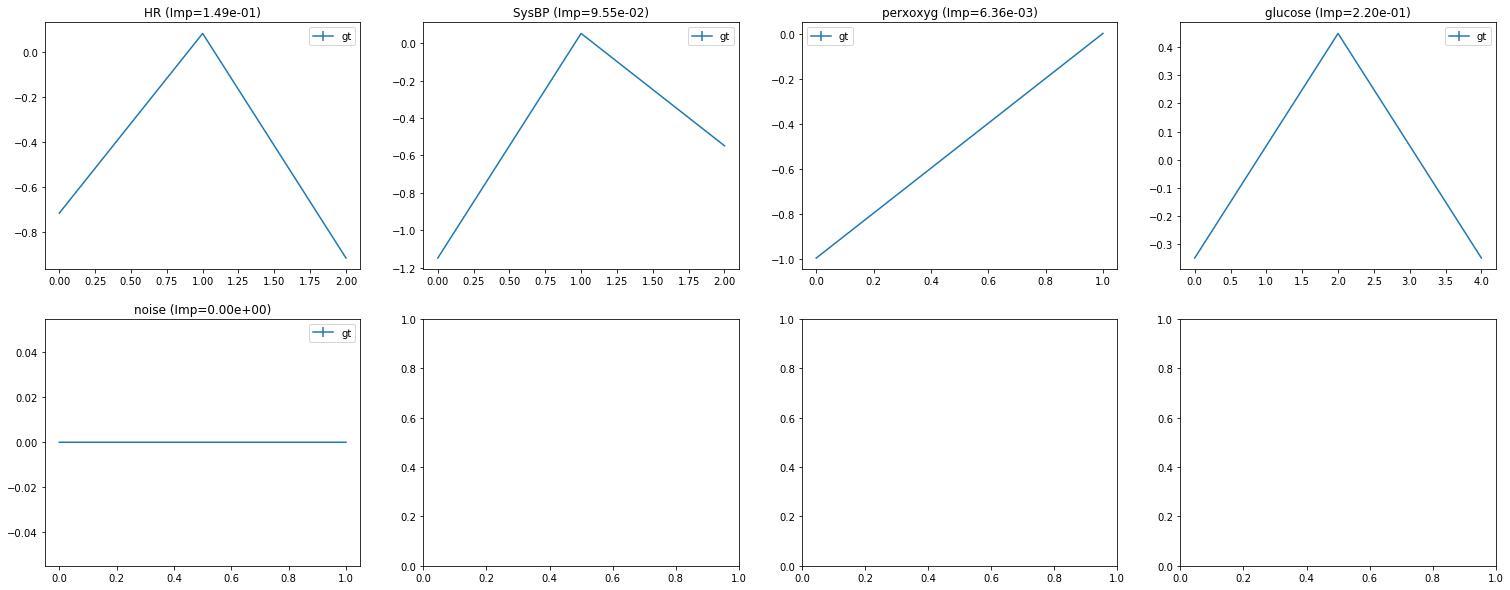

In [128]:
fig, ax = vis_main_effects({'gt': gt_df})

## GAM MDP Summary table

AttributeError: 'function' object has no attribute 'keys'

In [404]:
tmp(all_X.values)

(200000,)

In [439]:
def scale_df(gt_df, df):
    ''' Scale df to be as close to gt_df under weighted l1 distance '''
    with Timer('Do CVX optimization'):
        scaling = cvx.Variable()
        obj = 0.
        # Ignore the offset
        for (gt_idx, gt_row), (m_idx, m_row) in zip(gt_df.iloc[1:].iterrows(), df.iloc[1:].iterrows()):
            obj += cvx.sum(cvx.multiply(cvx.abs((scaling * m_row.y) - gt_row.y), np.array(gt_row.counts) / np.sum(gt_row.counts)))
        
        constraints = [scaling >= 0.]

        prob = cvx.Problem(cvx.Minimize(obj), constraints)
        prob.solve()

        the_scale = scaling.value
    
    scaled_df = df.copy()
    scaled_df.y *= the_scale
    return the_scale, scaled_df, obj.value


def get_predict_fn(model):
    def predict_fn(X):
        X = torch.as_tensor(X, device=device)
        with torch.no_grad():
            logits = process_in_chunks(model, X, batch_size=512)
            logits = check_numpy(logits)

        ret = logits
        return ret
    return predict_fn


def run(models, all_X, gt_df):
    results = []
    results_df = {}
    orig_df = {}
    
    for name, path in models.items():
        if 'cirl' in name or 'mma' in name: # Load MMA
            model = load_mma_model(path)
            df = extract_GAM(all_X, model)
        else:
            model = load_best_model_from_trained_dir(path)
            model.to(device)
            df = extract_GAM(all_X, get_predict_fn(model))

        the_scale, scaled_df, dis = scale_df(gt_df, df)

        result = {}
        result['name'] = name
        result['l1_dis'] = dis
        result['scale'] = the_scale
        results.append(result)

        results_df[name] = scaled_df
        orig_df[name] = df
    return results, results_df, orig_df

In [409]:
models = {
#     'linear-airl': '1001_gammdp_linear_dlr0.001_aob1_sh0_ls0.0_ug20_s124_bs512_dn0.1_dns0.2',
    'mma': '1015_Scurrent_gammdp_uniform_g0.9',
    'cirl': '1015_gammdp_uniform_g0.9',
    'gam-airl': '1004_gammdp_scurrent_gam_dlr0.0002_sh1_nl2_nt200_ad1_td1_od0.0_ld0.0_cs0.5_an3000_ug20_s148_bs512_dns0',
    'linear-cairl': '1001_gammdp_linear_dlr0.001_aob1_sh0_ls0.0_ug20_s124_bs512_dn0.1_dns0.2',
    'gam-cairl': '1001_gammdp_gam_new_dlr0.0002_sh1_nl1_nt100_ad0_td2_od0.0_ld0.0_cs0.5_an3000_ug20_s33_bs512_dns0',
#     'nodegam': '0927_sim_gam_dlr0.001_nl3_nt50_ad0_td3_od0.0_ld0.5_cs1.0_an2000_ug20_s321_bs512_dn0.1_dns0.1',
#     'nodegam': '0730_mg0.9_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000',
#     'linear': '0730_gammdp_linear_s321_lr0.0003_bs512_ud20_dn0.0_dns10',
#     'nodegam_g0.99': '0730_mg0.99_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000',
#     'nodegam_g0.8': '0730_mg0.8_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000',
#     'nodegam_g0.5': '0730_mg0.5_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000',
#     'nodegam_g0.3': '0730_mg0.3_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000',
#     'nodegam_g0.1': '0730_mg0.1_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000',
}

In [410]:
results, results_df, orig_df = run(models, all_X, gt_df)

rsync -avzL v:/h/kingsley/irl_nodegam/logs/1015_Scurrent_gammdp_uniform_g0.9 ./logs/
Finish "Do CVX optimization" in 11.7s
rsync -avzL v:/h/kingsley/irl_nodegam/logs/1015_gammdp_uniform_g0.9 ./logs/
Finish "Do CVX optimization" in 11.7s
Finish "Do CVX optimization" in 11.7s
Finish "Do CVX optimization" in 2.2s
Finish "Do CVX optimization" in 11.6s


In [411]:
# models = {
#     'nodegam_shaping': '0730_shaping_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000',
# }
# tmp_results, tmp_results_df, tmp_orig_df = run(models)
# results += (tmp_results)
# results_df.update(tmp_results_df)
# orig_df.update(tmp_orig_df)

In [412]:
pd.DataFrame(results)

name    l1_dis                    scale
0           mma  0.471115    -1.02772154856819e-19
1          cirl  0.471115    6.510452449610312e-16
2      gam-airl  0.358019        3.306657653725921
3  linear-cairl  0.471115  -3.9281190695198386e-17
4     gam-cairl  0.281552         7.16656940544953

In [413]:
# results_df['orig_linear'] = orig_df['linear']
results_df['gt'] = gt_df

/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


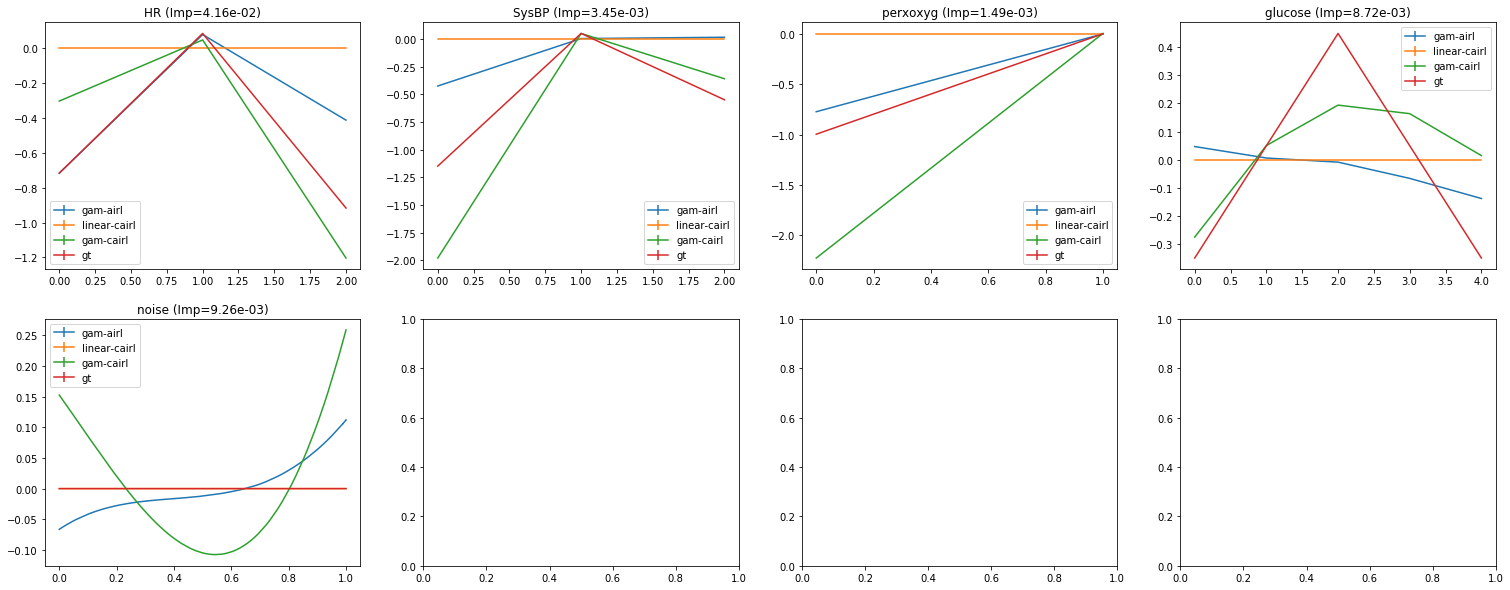

In [135]:
fig, ax = vis_main_effects(
    results_df, 
    model_names=['gt', 'gam-airl', 'linear-cairl', 'gam-cairl'],
)

### Paper graph

/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


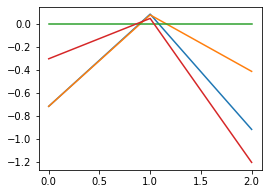

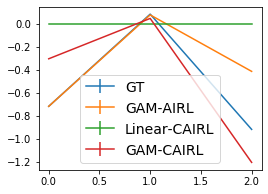

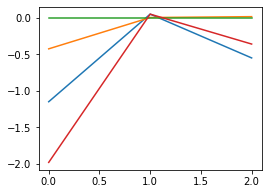

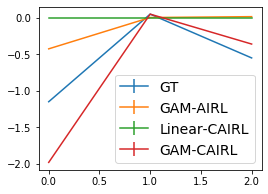

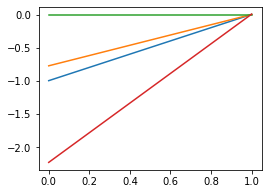

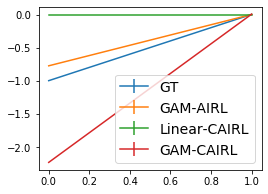

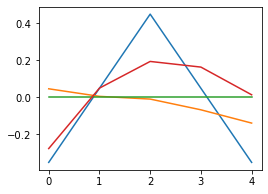

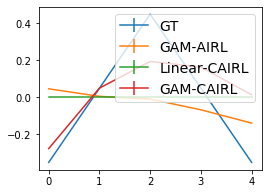

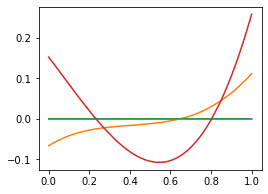

/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


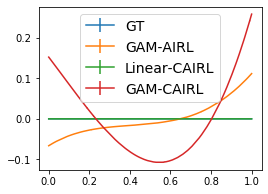

In [362]:
label_dict = {
    'gam-airl': 'GAM-AIRL',
    'linear-cairl': 'Linear-CAIRL',
    'gam-cairl': 'GAM-CAIRL',
    'gt': 'GT',
}

for f in ['HR', 'SysBP', 'perxoxyg', 'glucose', 'noise']:
    for legend in ['_no_legend', '']:
        fig, ax = vis_main_effects(results_df, feature_names=[f], model_names=['gt', 'gam-airl', 'linear-cairl', 'gam-cairl'], num_cols=1, figsize=(4, 3))

        # When plotting, we put the important ones last to overlay prev lines. Now legend shows the opposite
        handles, labels = ax.get_legend_handles_labels()

        font_size = 14
    #     if f == 'Na':
    #         font_size = 12
        ax.legend(handles, [label_dict[l] for l in labels], prop={'size': font_size})
        if legend == '_no_legend':
            ax.get_legend().remove()
        ax.set_title('')

        os.makedirs('./notebooks/figures/gammdp', exist_ok=True)
        fig.savefig(f'./notebooks/figures/gammdp/{f}{legend}.pdf', dpi=300, bbox_inches='tight')

## Linear MDP

In [136]:
# Load the expert data
with open('./data/sepsisSimData/linearMDP_N5000_g0.9_f0_expert_data.pkl', 'rb') as fp:
    data_linear = pickle.load(fp)

In [137]:
data_linear.keys()

dict_keys(['eps0.07', 'eps0.14', 'optimal', 'optimal_reward_mean', 'optimal_reward_std'])

In [138]:
data_linear['optimal_reward_mean'], data_linear['optimal_reward_std']

(1.7077173590502692, 0.007525676722868002)

In [139]:
all_lmdp_X = np.concatenate([data_linear['optimal']['train_D']['o'], data_linear['optimal']['test_D']['o']], axis=0)
all_lmdp_X = all_lmdp_X.reshape(-1, all_lmdp_X.shape[-1]) # Reshape from (N, T, D) to (NxT, D)
all_lmdp_X = pd.DataFrame(all_lmdp_X.astype(np.float32), columns=['HR', 'SysBP', 'perxoxyg', 'glucose', 'noise'])

In [140]:
hr_state_dict = {0: -0.3, 1: -0.6, 2: -0.9}  # linear
sysbp_state_dict = {0: -0.4, 1: -0.8, 2: -1.2}  # linear
percoxyg_state = {0: 0, 1: 0.6}  # linear
glucose_state_dict = {0: 0., 1: 0.2, 2: 0.4, 3: 0.6, 4: 0.8}  # linear

In [141]:
def gt_predict_fn(X):
    score = np.zeros(X.shape[0])
    
    for i in range(X.shape[0]):
        score[i] += hr_state_dict[X[i, 0]]
        score[i] += sysbp_state_dict[X[i, 1]]
        score[i] += percoxyg_state[X[i, 2]]        
        score[i] += glucose_state_dict[X[i, 3]]
    return score

In [142]:
gt_lmdp_df = extract_GAM(all_lmdp_X, gt_predict_fn)
gt_lmdp_df

feat_name  feat_idx  \
0    offset        -1   
1        HR         0   
2     SysBP         1   
3  perxoxyg         2   
4   glucose         3   
5     noise         4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                x  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

###  Summary Table

In [414]:
lmdp_models = {
    'mma': '1015_Scurrent_linearmdp_uniform_g0.9',
    'cirl': '1015_linearmdp_uniform_g0.9',
    'linear-airl': '1004_lmdp_scurrent_linear_dlr0.0004_sh1_ug20_s63_bs512_dns0',
    'gam-airl': '1004_lmdp_scurrent_gam_dlr0.0002_sh1_nl1_nt400_ad0_td2_od0.1_ld0.3_cs1.0_an3000_ug20_s81_bs512_dns0',
    'linear-cairl': '1001_lmdp_linear_new_dlr0.0002_sh0_ug20_s56_bs512_dns0', # lower reward but higher test_a 98...
#     'linear-cairl': '1001_lmdp_linear_new_dlr0.0002_sh1_ug20_s127_bs512_dn0.1_dns0.1', # higher reward but lower test_a 96.6
    'gam-cairl': '1001_lmdp_gam_new_dlr0.0002_sh0_nl1_nt100_ad1_td1_od0.0_ld0.0_cs1.0_an3000_ug20_s143_bs512_dn0.1_dns0.1',

#     'nodegam': '0804_lmdp_nodegam_s321_lr0.001_bs512_ud50_dn0.1_dns20_nl1_nt50_ad1_td1_od0.0_ld0.2_cs1.0_an2000',
#     'linear': '0730_lmdp_linear_s321_lr0.001_bs512_ud30_dn0.05_dns20',
}

In [415]:
lmdp_results, lmdp_results_df, lmdp_orig_df = run(lmdp_models, all_lmdp_X, gt_lmdp_df)

rsync -avzL v:/h/kingsley/irl_nodegam/logs/1015_Scurrent_linearmdp_uniform_g0.9 ./logs/
Finish "Do CVX optimization" in 12.2s
Finish "Do CVX optimization" in 4.4s
Finish "Do CVX optimization" in 3.2s
Finish "Do CVX optimization" in 12.0s
Finish "Do CVX optimization" in 2.9s
Finish "Do CVX optimization" in 3.3s


In [416]:
pd.DataFrame(lmdp_results)

name    l1_dis               scale
0           mma  0.049716   0.609055874473743
1          cirl  0.103155  0.5960195208742676
2   linear-airl  0.051260   13.75456064217747
3      gam-airl  0.210138  10.247950296206799
4  linear-cairl  0.016280  11.386308143891599
5     gam-cairl  0.072989    3.77477047560235

In [417]:
# results_df['orig_linear'] = orig_df['linear']
lmdp_results_df['gt'] = gt_lmdp_df
# lmdp_results_df['nodegam_orig'] = lmdp_orig_df['nodegam']

/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


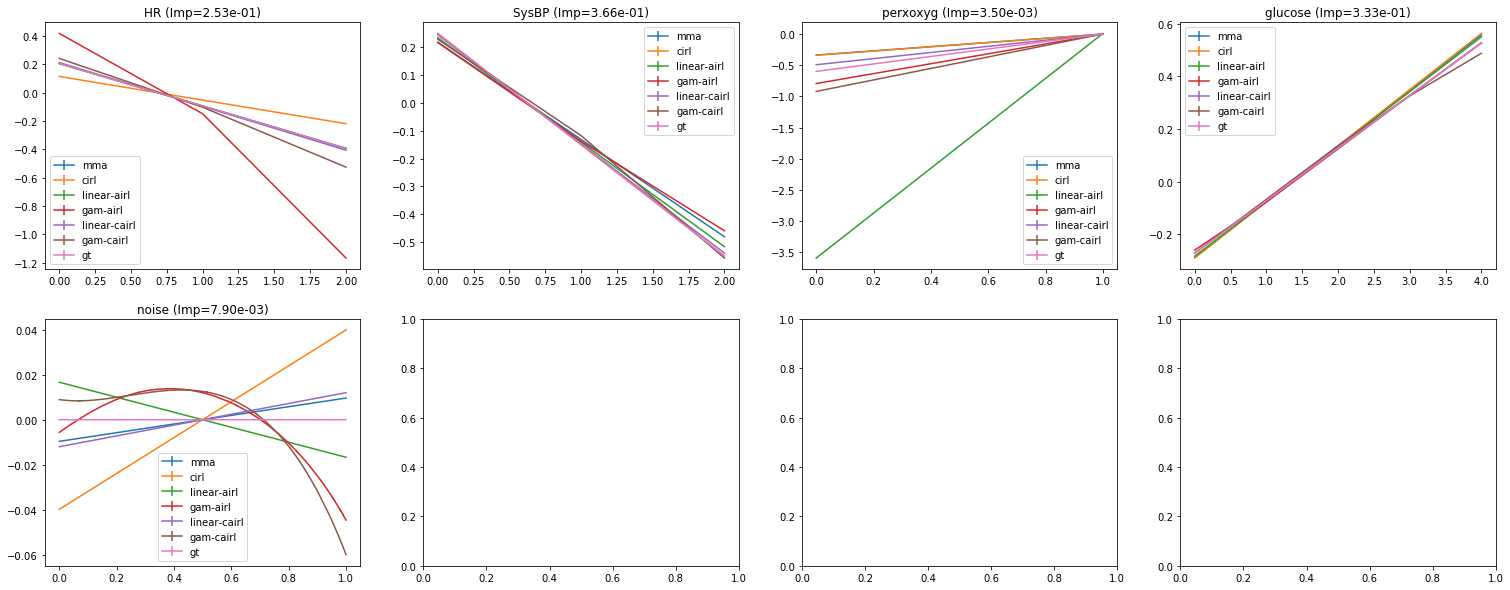

In [418]:
fig, ax = vis_main_effects(
    lmdp_results_df, 
    model_names=['gt', 'linear-airl', 'gam-airl', 'linear-cairl', 'gam-cairl']
)

### Paper graph

/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


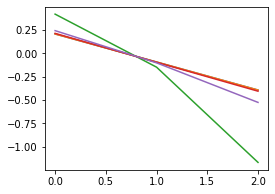

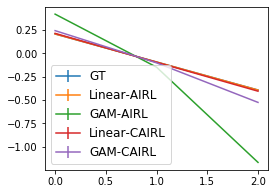

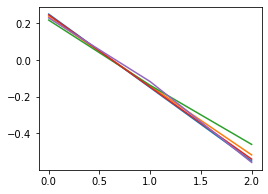

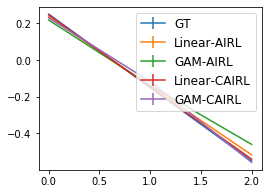

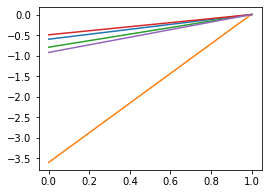

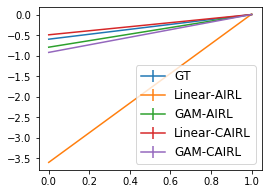

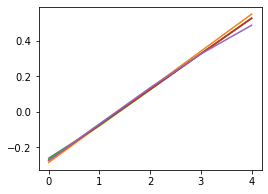

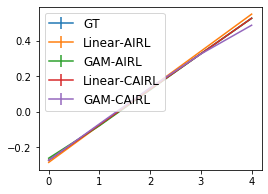

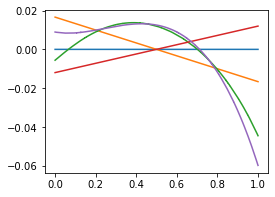

/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


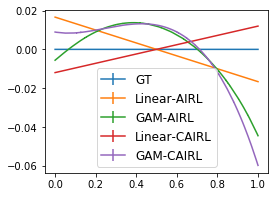

In [363]:
label_dict = {
    'linear-airl': 'Linear-AIRL',
    'gam-airl': 'GAM-AIRL',
    'linear-cairl': 'Linear-CAIRL',
    'gam-cairl': 'GAM-CAIRL',
    'gt': 'GT',
}

for f in ['HR', 'SysBP', 'perxoxyg', 'glucose', 'noise']:
    for legend in ['_no_legend', '']:
#     for legend in ['']:
        fig, ax = vis_main_effects(lmdp_results_df, feature_names=[f], model_names=['gt', 'linear-airl', 'gam-airl', 'linear-cairl', 'gam-cairl'], num_cols=1, figsize=(4, 3))

        # When plotting, we put the important ones last to overlay prev lines. Now legend shows the opposite
        handles, labels = ax.get_legend_handles_labels()

        font_size = 12
    #     if f == 'Na':
    #         font_size = 12
        ax.legend(handles, [label_dict[l] for l in labels], prop={'size': font_size})
        if legend == '_no_legend':
            ax.get_legend().remove()
        ax.set_title('')

        os.makedirs('./notebooks/figures/linearmdp', exist_ok=True)
        fig.savefig(f'./notebooks/figures/linearmdp/{f}{legend}.pdf', dpi=300, bbox_inches='tight')

# Simulation Gamma=0.5 

## Load expert data

In [425]:
# Load the expert data
with open('./data/sepsisSimData/gamMDP_N5000_g0.5_f0_expert_data.pkl', 'rb') as fp:
    data_g05 = pickle.load(fp)

In [426]:
data_g05.keys()

dict_keys(['eps0.07', 'eps0.14', 'optimal', 'optimal_reward_mean', 'optimal_reward_std'])

In [427]:
data_g05['optimal_reward_mean'], data_g05['optimal_reward_std']

(-0.3607323292732239, 0.008871392938058966)

In [428]:
data_g05['optimal']['test_D']['o'].shape

(5000, 20, 5)

In [429]:
all_X_g05 = np.concatenate([data_g05['optimal']['train_D']['o'], data_g05['optimal']['test_D']['o']], axis=0)
all_X_g05 = all_X_g05.reshape(-1, all_X_g05.shape[-1]) # Reshape from (N, T, D) to (NxT, D)
all_X_g05 = pd.DataFrame(all_X_g05.astype(np.float32), columns=['HR', 'SysBP', 'perxoxyg', 'glucose', 'noise'])

In [430]:
# all_next_states = np.empty((State.NUM_FULL_STATES, State.PHI_DIM), dtype=np.float32)

# for i in range(State.NUM_FULL_STATES):
#     all_next_states[i] = State(state_idx=i, idx_type='full')\
#         .get_phi_vector().astype(np.float32)

# all_X = pd.DataFrame(all_next_states, columns=['HR', 'SysBP', 'perxoxyg', 'glucose', 'noise'])
# all_X[:5]

## GAM MDP Ground truth

In [431]:
hr_state_dict_g05 = {0: -0.8, 1: 0, 2: -1} # non-linear
sysbp_state_dict_g05 = {0: -1.2, 1: 0, 2: -0.6} # non-linear
percoxyg_state_g05 = {0: -1, 1: 0} # non-linear
glucose_state_dict_g05 = {0: -0.8, 1: -0.4, 2: 0, 3: -0.4, 4: -0.8} # non-linear

In [432]:
def gt_predict_fn_g05(X):
    score = np.zeros(X.shape[0])
    
    for i in range(X.shape[0]):
        score[i] += hr_state_dict_g05[X[i, 0]]
        score[i] += sysbp_state_dict_g05[X[i, 1]]
        score[i] += percoxyg_state_g05[X[i, 2]]        
        score[i] += glucose_state_dict_g05[X[i, 3]]
    return score

In [433]:
gt_df_g05 = extract_GAM(all_X_g05, gt_predict_fn_g05)
gt_df_g05

feat_name  feat_idx  \
0    offset        -1   
1        HR         0   
2     SysBP         1   
3  perxoxyg         2   
4   glucose         3   
5     noise         4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      x  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

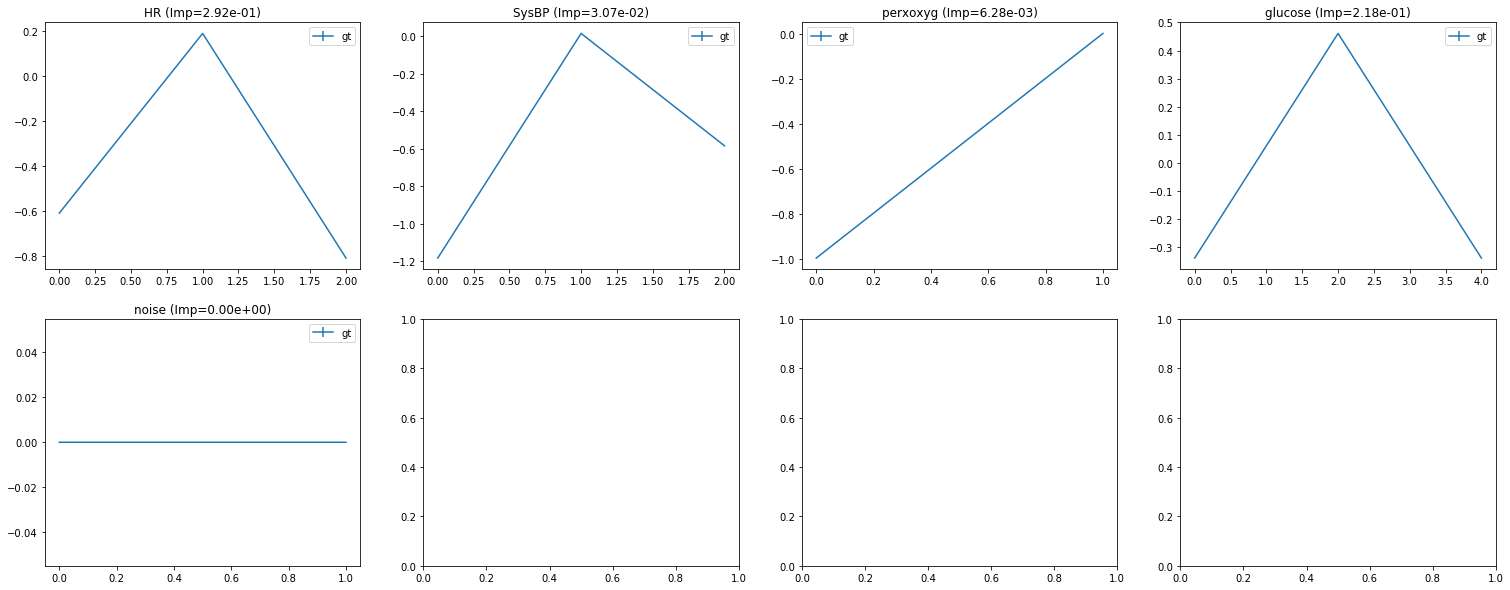

In [434]:
fig, ax = vis_main_effects({'gt': gt_df_g05})

## GAM MDP Summary table

In [440]:
# def scale_df(gt_df, df):
#     ''' Scale df to be as close to gt_df under weighted l1 distance '''
#     with Timer('Do CVX optimization'):
#         scaling = cvx.Variable()
#         obj = 0.
#         # Ignore the offset
#         for (gt_idx, gt_row), (m_idx, m_row) in zip(gt_df.iloc[1:].iterrows(), df.iloc[1:].iterrows()):
#             obj += cvx.sum(cvx.multiply(cvx.abs((scaling * m_row.y) - gt_row.y), np.array(gt_row.counts) / np.sum(gt_row.counts)))
        
#         constraints = [scaling >= 0.]

#         prob = cvx.Problem(cvx.Minimize(obj), constraints)
#         prob.solve()

#         the_scale = scaling.value
    
#     scaled_df = df.copy()
#     scaled_df.y *= the_scale
#     return the_scale, scaled_df, obj.value


# def get_predict_fn(model):
#     def predict_fn(X):
#         X = torch.as_tensor(X, device=device)
#         with torch.no_grad():
#             logits = process_in_chunks(model, X, batch_size=512)
#             logits = check_numpy(logits)

#         ret = logits
#         if len(logits.shape) == 2 and logits.shape[1] == 2:
#             ret = logits[:, 1] - logits[:, 0]
#         return ret
#     return predict_fn


# def run(models, all_X, gt_df):
#     results = []
#     results_df = {}
#     orig_df = {}
    
#     for name, path in models.items():
#         if name in results_df:
#             continue
#         model = load_best_model_from_trained_dir(path)
#         model.to(device)

#         df = extract_GAM(all_X, get_predict_fn(model))
#         the_scale, scaled_df, dis = scale_df(gt_df, df)

#         result = {}
#         result['name'] = name
#         result['l1_dis'] = dis
#         result['scale'] = the_scale
#         results.append(result)

#         results_df[name] = scaled_df
#         orig_df[name] = df
#     return results, results_df, orig_df

In [441]:
models_g05 = {
#     'linear-airl': '1001_gammdp_linear_dlr0.001_aob1_sh0_ls0.0_ug20_s124_bs512_dn0.1_dns0.2',
    'mma': '1015_Scurrent_gammdp_uniform_g0.5',
    'cirl': '1015_gammdp_uniform_g0.5',
    'gam-airl': '1013_gammdp_scurrent_gam_g0.5_dlr0.0002_sh0_nl1_nt400_ad0_td2_od0.0_ld0.0_cs0.5_an3000_ug20_s110_bs512_dn0.0_dns0',
    'linear-cairl': '1012_gammdp_linear_g0.5_dlr0.0002_sh1_ug20_s139_bs512_dn0.1_dns0.1',
    'gam-cairl': '1012_gammdp_gam_g0.5_dlr0.0004_sh1_nl1_nt400_ad1_td2_od0.0_ld0.0_cs0.5_an3000_ug20_s174_bs512_dn0.0_dns0',
#     'nodegam': '0927_sim_gam_dlr0.001_nl3_nt50_ad0_td3_od0.0_ld0.5_cs1.0_an2000_ug20_s321_bs512_dn0.1_dns0.1',
#     'nodegam': '0730_mg0.9_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000',
#     'linear': '0730_gammdp_linear_s321_lr0.0003_bs512_ud20_dn0.0_dns10',
#     'nodegam_g0.99': '0730_mg0.99_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000',
#     'nodegam_g0.8': '0730_mg0.8_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000',
#     'nodegam_g0.5': '0730_mg0.5_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000',
#     'nodegam_g0.3': '0730_mg0.3_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000',
#     'nodegam_g0.1': '0730_mg0.1_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000',
}

In [442]:
results_g05, results_df_g05, orig_df_g05 = run(models_g05, all_X_g05, gt_df_g05)

Finish "Do CVX optimization" in 11.9s
Finish "Do CVX optimization" in 11.8s
Finish "Do CVX optimization" in 4.1s
Finish "Do CVX optimization" in 11.9s
Finish "Do CVX optimization" in 12.0s


In [443]:
pd.DataFrame(results_g05)

name    l1_dis                   scale
0           mma  0.546889   -9.50163749740237e-15
1          cirl  0.546889  4.7225595677527625e-17
2      gam-airl  0.472934      2.8706599317287465
3  linear-cairl  0.546889  -3.685159938869274e-18
4     gam-cairl  0.345429         8.2511446332555

In [444]:
# results_df['orig_linear'] = orig_df['linear']
results_df_g05['gt'] = gt_df_g05

/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


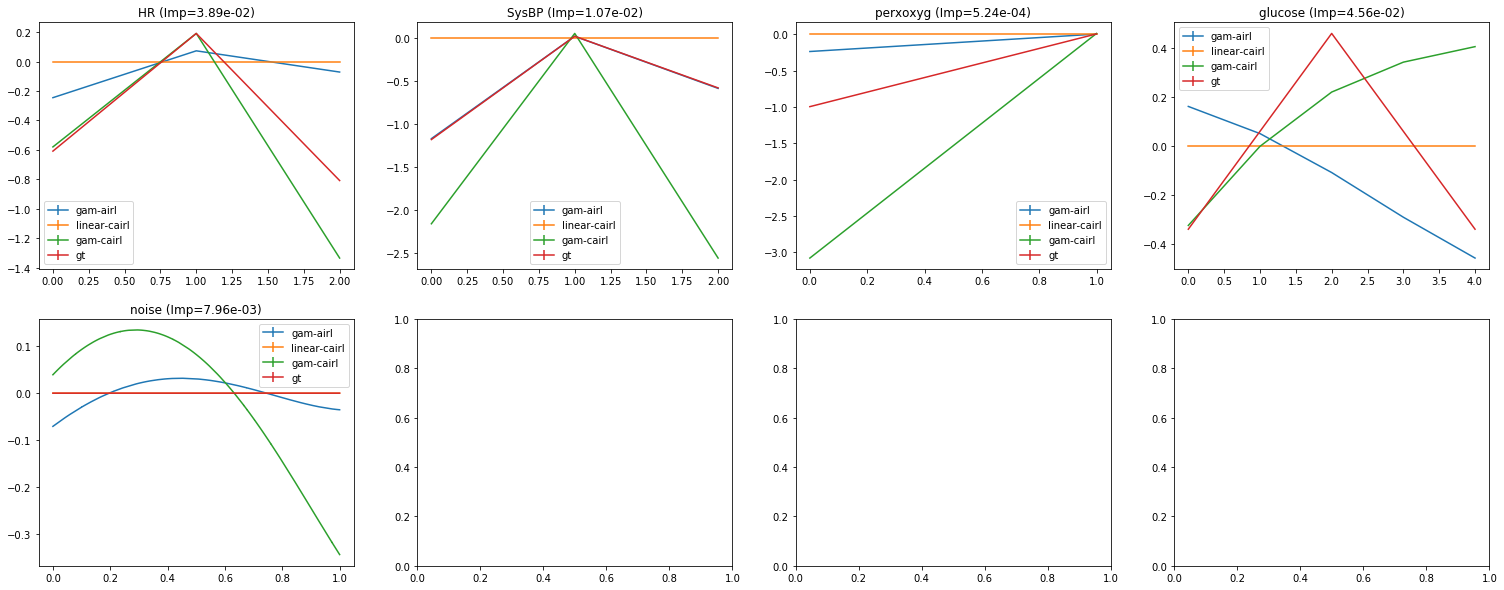

In [209]:
fig, ax = vis_main_effects(
    results_df_g05, 
#     model_names=['nodegam', '', 'linear', 'gt'],
)

## Linear MDP

In [445]:
# Load the expert data
with open('./data/sepsisSimData/linearMDP_N5000_g0.5_f0_expert_data.pkl', 'rb') as fp:
    data_linear_g05 = pickle.load(fp)

In [446]:
data_linear_g05.keys()

dict_keys(['eps0.07', 'eps0.14', 'optimal', 'optimal_reward_mean', 'optimal_reward_std'])

In [447]:
data_linear_g05['optimal_reward_mean'], data_linear_g05['optimal_reward_std']

(0.3448593174724578, 0.005064832862888423)

In [448]:
all_lmdp_X_g05 = np.concatenate([data_linear_g05['optimal']['train_D']['o'], data_linear_g05['optimal']['test_D']['o']], axis=0)
all_lmdp_X_g05 = all_lmdp_X_g05.reshape(-1, all_lmdp_X_g05.shape[-1]) # Reshape from (N, T, D) to (NxT, D)
all_lmdp_X_g05 = pd.DataFrame(all_lmdp_X_g05.astype(np.float32), columns=['HR', 'SysBP', 'perxoxyg', 'glucose', 'noise'])

In [449]:
hr_state_dict_linear_g05 = {0: -0.3, 1: -0.6, 2: -0.9}  # linear
sysbp_state_dict_linear_g05 = {0: -0.4, 1: -0.8, 2: -1.2}  # linear
percoxyg_state_linear_g05 = {0: 0, 1: 0.6}  # linear
glucose_state_dict_linear_g05 = {0: 0., 1: 0.2, 2: 0.4, 3: 0.6, 4: 0.8}  # linear

In [450]:
def gt_predict_fn_linear_g05(X):
    score = np.zeros(X.shape[0])
    
    for i in range(X.shape[0]):
        score[i] += hr_state_dict_linear_g05[X[i, 0]]
        score[i] += sysbp_state_dict_linear_g05[X[i, 1]]
        score[i] += percoxyg_state_linear_g05[X[i, 2]]        
        score[i] += glucose_state_dict_linear_g05[X[i, 3]]
    return score

In [451]:
gt_lmdp_df_g05 = extract_GAM(all_lmdp_X_g05, gt_predict_fn_linear_g05)
gt_lmdp_df_g05

feat_name  feat_idx  \
0    offset        -1   
1        HR         0   
2     SysBP         1   
3  perxoxyg         2   
4   glucose         3   
5     noise         4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 x  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

###  Summary Table

In [452]:
lmdp_models_g05 = {
    'mma': '1015_Scurrent_linearmdp_uniform_g0.5',
    'cirl': '1015_linearmdp_uniform_g0.5',
    'linear-airl': '1013_lmdp_scurrent_linear_g0.5_dlr0.0002_sh0_ug20_s70_bs512_dn0.0_dns0',
    'gam-airl': '1013_lmdp_scurrent_gam_g0.5_dlr0.0004_sh1_nl1_nt400_ad1_td1_od0.1_ld0.0_cs1.0_an3000_ug20_s148_bs512_dn0.1_dns0.1',
    'linear-cairl': '1012_lmdp_linear_g0.5_dlr0.0002_sh0_ug20_s66_bs512_dn0.1_dns0.2', 
    'gam-cairl': '1012_lmdp_gam_g0.5_dlr0.0004_sh1_nl1_nt200_ad0_td1_od0.0_ld0.3_cs1.0_an3000_ug20_s19_bs512_dn0.0_dns0',
}

In [453]:
lmdp_results_g05, lmdp_results_df_g05, lmdp_orig_df_g05 = run(lmdp_models_g05, all_lmdp_X_g05, gt_lmdp_df_g05)

Finish "Do CVX optimization" in 11.8s
Finish "Do CVX optimization" in 11.7s
Finish "Do CVX optimization" in 4.2s
Finish "Do CVX optimization" in 4.4s
Finish "Do CVX optimization" in 3.6s
Finish "Do CVX optimization" in 11.7s


In [454]:
pd.DataFrame(lmdp_results_g05)

name    l1_dis                   scale
0           mma  0.460277  -5.093675333020728e-19
1          cirl  0.460277  -5.133158726424541e-19
2   linear-airl  0.358082       6.796789012457608
3      gam-airl  0.233864      1.6279333341668198
4  linear-cairl  0.343215      26.988799627567975
5     gam-cairl  0.195361       7.754894844416407

In [198]:
# results_df['orig_linear'] = orig_df['linear']
lmdp_results_df_g05['gt'] = gt_lmdp_df_g05
# lmdp_results_df['nodegam_orig'] = lmdp_orig_df['nodegam']

/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


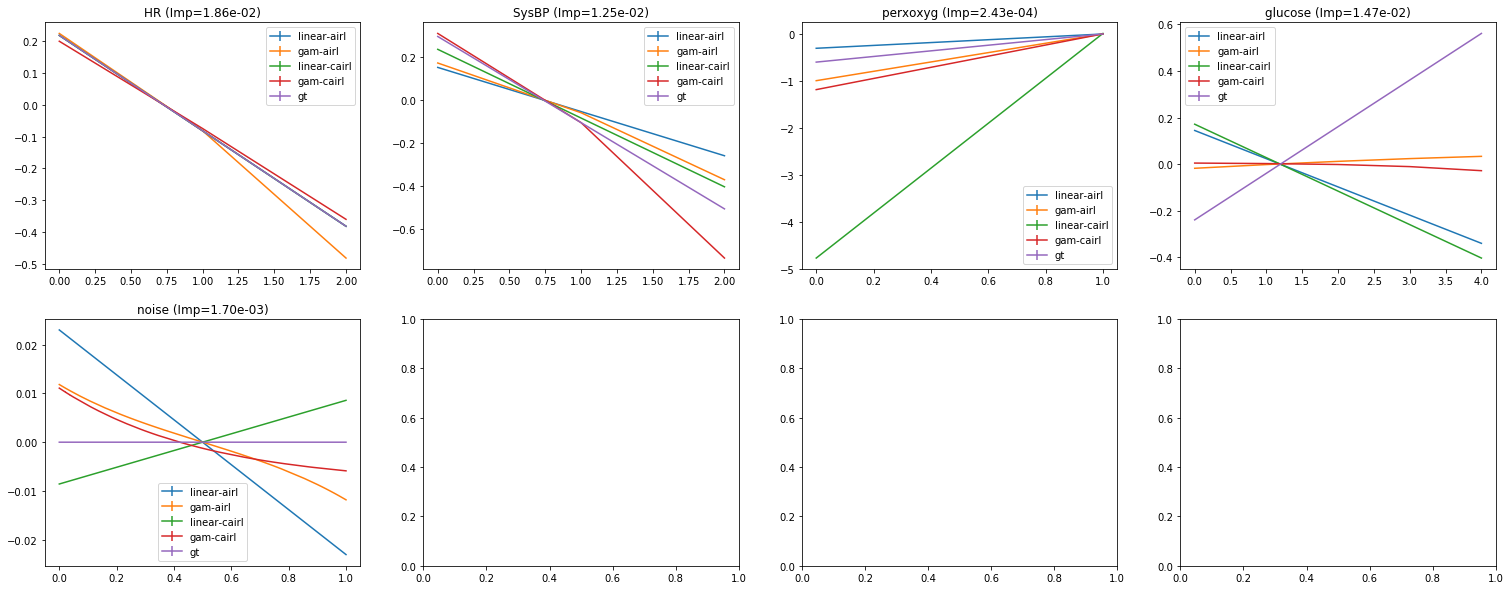

In [199]:
fig, ax = vis_main_effects(
    lmdp_results_df_g05, 
#     model_names=['nodegam', 'linear', 'gt']
)

## Model graph (OLD)

In [51]:
def get_predict_fn(model):
    def predict_fn(X):
        X = torch.as_tensor(X, device=device)
        with torch.no_grad():
            logits = process_in_chunks(model, X, batch_size=512)
            logits = check_numpy(logits)

        ret = logits
        if len(logits.shape) == 2 and logits.shape[1] == 2:
            ret = logits[:, 1] - logits[:, 0]
        return ret
    return predict_fn

In [52]:
device = 'cuda'

In [20]:
model = load_best_model_from_trained_dir('0730_mg0.9_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000')
model.to(device)

rsync -avzL v:/h/kingsley/irl_nodegam/logs/hparams/0730_mg0.9_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000 ./logs/hparams/
rsync -avzL v:/h/kingsley/irl_nodegam/logs/0730_mg0.9_gammdp_nodegam_s321_lr0.0005_bs512_ud30_dn0.2_dns10_nl3_nt20_ad0_td2_od0.0_ld0.0_cs1.0_an3000 ./logs/


AIRL_NODEGAM_Lightning(
  (choice_fn): EM15Temp()
  (g): Sequential(
    (0): MinMaxNormalize()
    (1): GAMBlock(
      (0): GAM_ODST(in_features=5, num_trees=20, depth=2, tree_dim=1, flatten_output=True)
      (1): GAM_ODST(in_features=5, num_trees=20, depth=2, tree_dim=1, flatten_output=True)
      (2): GAM_ODST(in_features=5, num_trees=20, depth=2, tree_dim=1, flatten_output=True)
    )
  )
)

In [21]:
df = extract_GAM(all_X, get_predict_fn(model))

In [22]:
df

feat_name  feat_idx                                                  x  \
0    offset        -1                                               None   
1        HR         0                                    [0.0, 1.0, 2.0]   
2     SysBP         1                                    [0.0, 1.0, 2.0]   
3  perxoxyg         2                                         [0.0, 1.0]   
4   glucose         3                          [0.0, 1.0, 2.0, 3.0, 4.0]   
5     noise         4  [2.5764418296603253e-06, 1.0414624739496503e-0...   

                                                   y  importance  \
0                               [-3.906280893778801]   -1.000000   
1                  [-3.070658, 0.29807115, 0.507663]    0.547867   
2               [-1.1400347, 0.18222958, -2.6118555]    0.338105   
3                          [-5.8268943, 0.018647278]    0.037176   
4  [-0.2870419, 0.019108057, 0.22485614, 0.246846...    0.147482   
5  [0.26193318, 0.26192173, 0.26189741, 0.2618950...    0.308558   

                                              counts  
0                                           [200000]  
1                              [17842, 179817, 2341]  
2                              [2692, 185538, 11770]  
3                                      [638, 199362]  
4                [51380, 84709, 37997, 14562, 11352]  
5  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...

/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


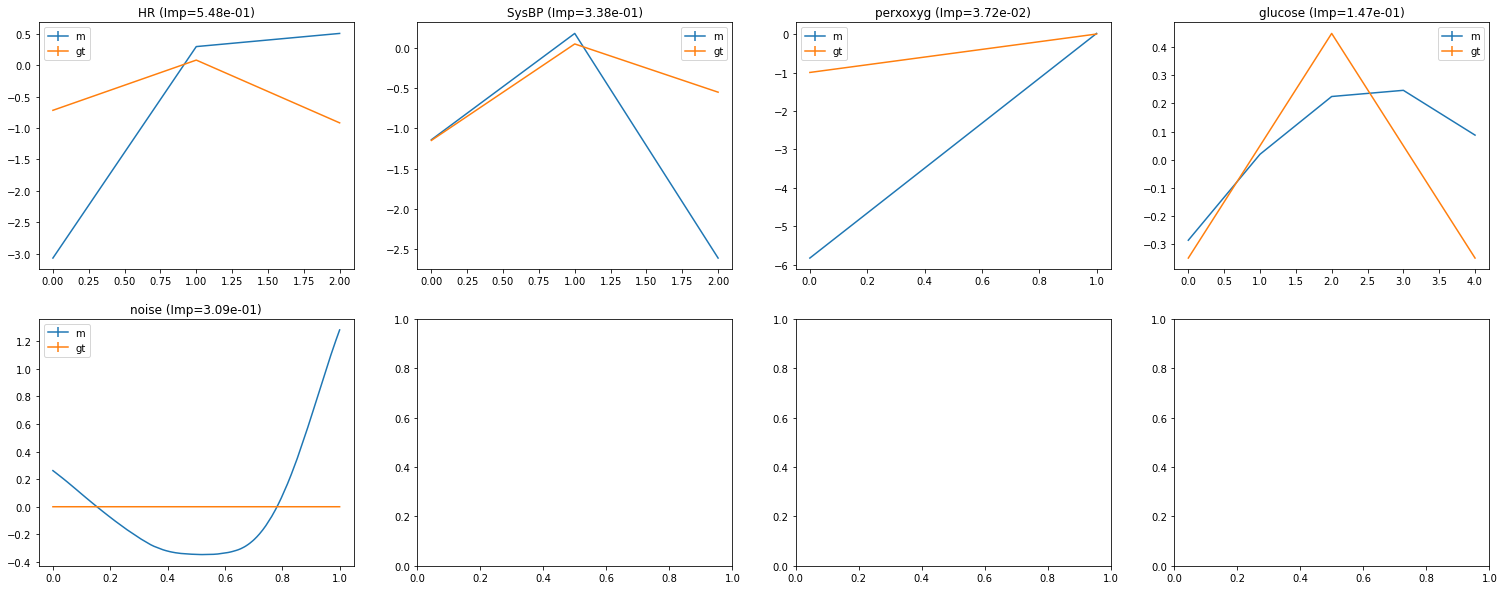

In [23]:
fig, ax = vis_main_effects({'m': df, 'gt': gt_df})

### Tuning the scaling

In [98]:
def scale_df(gt_df, df):
    ''' Scale df to be as close to gt_df under weighted l1 distance '''
    with Timer('Do CVX optimization'):
        scaling = cvx.Variable()
        obj = 0.
        # Ignore the offset
        for (gt_idx, gt_row), (m_idx, m_row) in zip(gt_df.iloc[1:].iterrows(), df.iloc[1:].iterrows()):
            obj += cvx.sum(cvx.multiply(cvx.abs((scaling * m_row.y) - gt_row.y), np.array(gt_row.counts) / np.sum(gt_row.counts)))
        
        constraints = [scaling >= 0.]

        prob = cvx.Problem(cvx.Minimize(obj), constraints)
        prob.solve()

        the_scale = scaling.value
    
    scaled_df = df.copy()
    scaled_df.y *= the_scale
    return the_scale, scaled_df, obj.value

In [25]:
# scaling = cvx.Variable()
# obj = 0.
# # Ignore the offset
# for (gt_idx, gt_row), (m_idx, m_row) in zip(gt_df.iloc[1:].iterrows(), df.iloc[1:].iterrows()):
#     obj += cvx.sum(cvx.multiply(cvx.abs((scaling * m_row.y) - gt_row.y), np.array(gt_row.counts) / np.sum(gt_row.counts)))
# prob = cvx.Problem(cvx.Minimize(obj))
# prob.solve()
# scaled_df = df.copy()
# scaled_df.y *= scaling.value

In [26]:
the_scale, scaled_df, dis = scale_df(gt_df, df)

Finish "Do CVX optimization" in 12.4s


/scratch/gobi1/kingsley/envs/cu101/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


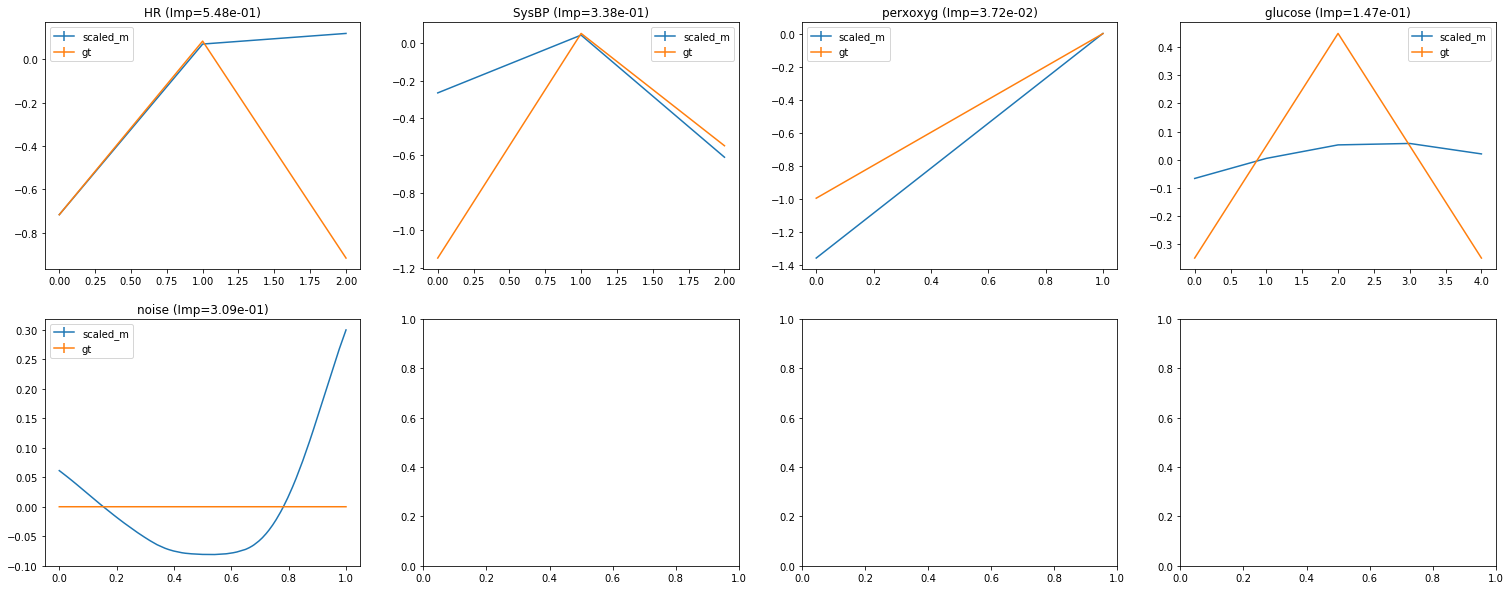

In [27]:
fig, ax = vis_main_effects({'scaled_m': scaled_df, 'gt': gt_df})

## Plot the scatter plot

Ground truth: read the reward definition in the LinearMDP class

`
reward = 0.5
if self.state.hr_state != 0: # linear decreasing
    reward -= 0.3 * (self.state.hr_state - 0)
if self.state.sysbp_state != 0: # linear decreasing
    reward -= 0.3 * (self.state.sysbp_state - 0)
if self.state.percoxyg_state != 1: # only 2 states, so linear
    reward -= 1 # Perctange of Oxygen level of your blood
if self.state.glucose_state != 2: # linearly increasing
    reward += 0.2 * (self.state.glucose_state - 4)
`

In [22]:
gt_reward = [
    0, -0.3, -0.6, # HR
    0, -0.3, -0.6, # BP
    -1, 0, # Oercentage of oxgen
    -0.8, -0.6, 0, -0.2, 0, # glucose
]

In [23]:
df2

feat_name  feat_idx                          x  \
0    offset        -1                       None   
1        HR         0            [0.0, 1.0, 2.0]   
2     SysBP         1            [0.0, 1.0, 2.0]   
3  perxoxyg         2                 [0.0, 1.0]   
4   glucose         3  [0.0, 1.0, 2.0, 3.0, 4.0]   
5  diabetes         4                 [0.0, 1.0]   

                                                   y  importance  \
0                               [-48.83352266947429]   -1.000000   
1                 [4.4995346, 0.91521454, -5.414749]    3.609833   
2                [3.797221, -0.45571637, -3.3415043]    2.531481   
3                            [-10.486954, 10.486954]   10.486954   
4  [-4.162778, -3.096654, 3.554309, 0.9529066, 2....    2.903773   
5                              [-23.81737, 23.81737]   23.817369   

                      counts  
0                     [1440]  
1            [480, 480, 480]  
2            [480, 480, 480]  
3                 [720, 720]  
4  [288, 288, 288, 288, 288]  
5                 [720, 720]

In [24]:
gam_reward = np.concatenate(df2.iloc[1:5].y.values, axis=0)
gam_reward

array([  4.4995346 ,   0.91521454,  -5.414749  ,   3.797221  ,
        -0.45571637,  -3.3415043 , -10.486954  ,  10.486954  ,
        -4.162778  ,  -3.096654  ,   3.554309  ,   0.9529066 ,
         2.7522154 ], dtype=float32)

In [32]:
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt

SpearmanrResult(correlation=0.9536615349206118, pvalue=4.4778501272738475e-07)
(0.9219018649126001, 7.430328809777048e-06)


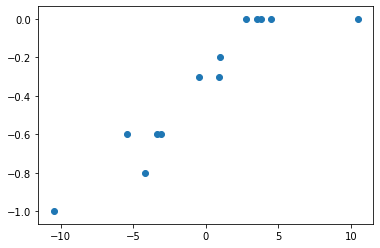

In [35]:
plt.scatter(gam_reward, gt_reward)
print(spearmanr(gam_reward, gt_reward))
print(pearsonr(gam_reward, gt_reward))

In [20]:
gt_df = df.copy()
gt_df

feat_name  feat_idx                          x  \
0    offset        -1                       None   
1        HR         0            [0.0, 1.0, 2.0]   
2     SysBP         1            [0.0, 1.0, 2.0]   
3  perxoxyg         2                 [0.0, 1.0]   
4   glucose         3  [0.0, 1.0, 2.0, 3.0, 4.0]   
5  diabetes         4                 [0.0, 1.0]   

                                                   y  importance  \
0                              [0.12890052795410156]   -1.000000   
1          [0.019819418, -8.009374e-08, -0.01981934]    0.013213   
2          [0.027471146, 8.009374e-08, -0.027471224]    0.018314   
3                          [-0.76956743, 0.76956743]    0.769567   
4  [-0.05982876, -0.02991438, 0.0, 0.02991438, 0....    0.035897   
5                            [-0.5689979, 0.5689979]    0.568998   

                      counts  
0                     [1440]  
1            [480, 480, 480]  
2            [480, 480, 480]  
3                 [720, 720]  
4  [288, 288, 288, 288, 288]  
5                 [720, 720]

In [ ]:
gt_df

In [19]:
from lib.sepsis_simulator.sepsisSimDiabetes.MDP import GAMMDP, LinearMDP

# MIMIC3 plotting

## Load expert data

In [179]:
loader = HypotensionDataset.make_loader(
    split='all',
    batch_size=128,
    shuffle=False,
    num_workers=2,
    data_kwargs=dict(do_normalize=False),
)

In [180]:
all_next_states = []
for exp_batch in loader:
    states, actions, next_states, dones = HypotensionDataset.extract_s_and_a_pairs(exp_batch['x_list'], state_type='all')
    all_next_states.append(next_states)

all_next_states = torch.cat(all_next_states, dim=0)
all_next_states.shape

torch.Size([253174, 74])

Make it back to pandas to include column information and unnormalize it!

In [181]:
all_X_mimic3 = pd.DataFrame(all_next_states.numpy(), columns=HypotensionDataset.all_cols)
all_X_mimic3.head()

age  is_F  surg_ICU  is_not_white  is_emergency  is_urgent   dbp  \
0  76.970840   1.0       1.0           0.0           1.0        0.0  30.0   
1  76.970840   1.0       1.0           0.0           1.0        0.0  52.0   
2  76.970840   1.0       1.0           0.0           1.0        0.0  30.0   
3  76.970840   1.0       1.0           0.0           1.0        0.0  30.0   
4  78.788818   0.0       1.0           0.0           0.0        0.0  39.0   

   fio2     hr   map    sbp  spontaneousrr   spo2       temp  urine  \
0  21.0  120.0  48.0  118.0           31.0   98.0  36.722221    5.0   
1  21.0  119.0  69.0  122.0           39.0   96.0  36.722221    0.0   
2  21.0   98.0  40.0   60.0           19.0   80.0  36.722221    0.0   
3  21.0  134.0  40.0   60.0           40.0   80.0  36.722221    0.0   
4  50.0   73.0  52.0   86.0           14.0  100.0  36.200001  100.0   

      weight   bun  magnesium  platelets  sodium    alt        hct    po2  \
0  82.000000  35.0        2.0      169.0   132.0  671.0  18.000000   95.0   
1  82.000000  35.0        2.0      143.0   132.0  671.0  18.000000   87.0   
2  76.400002  35.0        2.0      152.0   132.0  671.0  18.000000  239.0   
3  76.400002  35.0        2.0      152.0   132.0  671.0  18.000000   72.0   
4  80.900002  23.0        2.0      135.0   136.0   34.0  33.400002  328.0   

      ast  potassium        wbc  bicarbonate  creatinine  lactate  pco2  \
0  2661.0        4.2  14.600000         16.0         2.1      8.0  40.0   
1  2661.0        4.2  16.200001         11.0         2.1     13.0  29.0   
2  2661.0        5.3  20.600000          9.0         2.1      8.4  43.0   
3  2661.0        5.3  20.600000          9.0         2.1      8.4  60.0   
4    30.0        4.5  23.900000         25.0         1.0      3.8  44.0   

   bilirubin_total  glucose  inr   hgb   GCS  dbp_ind  fio2_ind  hr_ind  \
0             10.0    336.0  1.4   8.9  15.0      1.0       0.0     1.0   
1             10.0    336.0  1.4   8.9  15.0      1.0       0.0     1.0   
2             10.1    122.0  1.4   5.0  15.0      1.0       0.0     1.0   
3             10.1    122.0  1.4   5.0  15.0      1.0       0.0     1.0   
4              0.3    172.0  1.3  10.5   3.0      1.0       0.0     1.0   

   map_ind  sbp_ind  spontaneousrr_ind  spo2_ind  temp_ind  urine_ind  \
0      1.0      1.0                1.0       1.0       1.0        1.0   
1      1.0      1.0                1.0       1.0       0.0        1.0   
2      1.0      1.0                1.0       1.0       0.0        1.0   
3      1.0      1.0                1.0       1.0       0.0        0.0   
4      1.0      1.0                1.0       1.0       1.0        1.0   

   weight_ind  bun_ind  magnesium_ind  platelets_ind  sodium_ind  alt_ind  \
0         0.0      0.0            0.0            1.0         0.0      0.0   
1         0.0      0.0            0.0            1.0         0.0      0.0   
2         1.0      0.0            0.0            1.0         0.0      0.0   
3         0.0      0.0            0.0            0.0         0.0      0.0   
4         0.0      0.0            0.0            0.0         0.0      0.0   

   hct_ind  po2_ind  ast_ind  potassium_ind  wbc_ind  bicarbonate_ind  \
0      1.0      0.0      0.0            0.0      1.0              0.0   
1      1.0      1.0      0.0            0.0      1.0              1.0   
2      1.0      1.0      0.0            1.0      1.0              1.0   
3      1.0      1.0      0.0            0.0      0.0              1.0   
4      0.0      0.0      0.0            0.0      0.0              0.0   

   creatinine_ind  lactate_ind  pco2_ind  bilirubin_total_ind  glucose_ind  \
0             0.0          0.0       0.0                  0.0          0.0   
1             0.0          1.0       1.0                  0.0          0.0   
2             0.0          1.0       1.0                  1.0          1.0   
3             0.0          0.0       1.0                  0.0          1.0   
4             0.0      

In [83]:
# Unnormalize them
# filtered_cols_idx = [i for i, c in enumerate(all_X.columns) if c in HypotensionDataset.cols_norm]
# filtered_mean = [HypotensionDataset.cols_norm_mean_dict[c] for i, c in enumerate(all_X.columns) if c in HypotensionDataset.cols_norm]
# filtered_std = [HypotensionDataset.cols_norm_std_dict[c] for i, c in enumerate(all_X.columns) if c in HypotensionDataset.cols_norm]

# def unnormalize(all_X):
#     return HypotensionDataset.pp.inverse_transform(all_X)

# all_X = pd.DataFrame(unnormalize(all_X.values), columns=HypotensionDataset.all_cols)
# all_X.head()

In [182]:
all_X_mimic3.age.min()

18.020918

## Model graph

In [183]:
from lib.nodegam.utils import bin_data
all_X_mimic3 = bin_data(all_X_mimic3, max_n_bins=256)

bin features age with uniq val 7134 to only 256
bin features temp with uniq val 276 to only 256
bin features urine with uniq val 334 to only 256
bin features weight with uniq val 1150 to only 256
bin features platelets with uniq val 573 to only 256
bin features alt with uniq val 1151 to only 256
bin features hct with uniq val 321 to only 256
bin features po2 with uniq val 471 to only 256
bin features ast with uniq val 1464 to only 256
bin features wbc with uniq val 480 to only 256
bin features bilirubin_total with uniq val 284 to only 256
bin features glucose with uniq val 448 to only 256
bin features total_all_prev_vasos with uniq val 70044 to only 256
bin features total_all_prev_fluids with uniq val 7036 to only 256
bin features total_last_8hrs_vasos with uniq val 80214 to only 256
bin features total_last_8hrs_fluids with uniq val 4501 to only 256


In [87]:
from lib.nodegam.arch import GAMAdditiveMixin
from lib.nodegam.utils import extract_GAM

In [184]:
def get_dfs(the_dirs, all_X):
    dfs = []
    for the_dir in the_dirs:
        model = load_best_model_from_trained_dir(the_dir, target='best')
        # model = load_best_model_from_trained_dir(the_dir, target='last')
        model.to(device)
        
        X_in = HypotensionDataset.extract_s_by_state_type(all_X, model.hparams.disc_state_type)
        
        pp_postfix = '' if model.preprocess == 'quantile' else '_standard'
        path = pjoin('./data/model-data3/', f'pp{pp_postfix}.pkl')
        with open(path, 'rb') as fp:
            pp = pickle.load(fp)

        def normalize(x):
            x = pp.subset_transform(x, columns=HypotensionDataset.get_state_names_by_type(model.hparams.disc_state_type))
            return x
        
        gam_model = model.disc.g
        if isinstance(gam_model, GAMAdditiveMixin):
            df = gam_model.extract_additive_terms(X_in, device=device, batch_size=512, norm_fn=normalize)
        else:
            def predict_fn(x):
                x = pp.subset_transform(x, columns=HypotensionDataset.get_state_names_by_type(model.hparams.disc_state_type))
                x = torch.from_numpy(x).to(device)
                return model.disc(x).cpu().numpy()
            
            with torch.no_grad():
                df = extract_GAM(X_in, predict_fn, predict_type='regression')
            
        dfs.append(df)
        del model
    return dfs

### Best GAM and Linear

In [285]:
gam_dfs = get_dfs([
    f'1017_mimic3_best_f{fold}__gam_dlr0.0008_aob1_ls0.005_aGAM_nl3_nt200_ad0_td4_ld0.5_cs0.5_an3000_la0_ll1_od0.1_fnl3_fdr0.5_glr0.0008_bca0.5_s190_dn0.1_dns0.8' for fold in range(5)
], all_X_mimic3)

  3%|▎         | 7/219 [00:00<00:03, 57.23it/s]

Finish "Run values through model" in 34.6s


100%|██████████| 219/219 [00:06<00:00, 35.40it/s]


Finish "Extract values" in 6.3s


  0%|          | 0/225 [00:00<?, ?it/s]

Finish "Purify interactions to main effects" in 1.6s
Finish "Center main effects" in 6ms


100%|██████████| 225/225 [00:03<00:00, 67.34it/s]


Finish "Construct table" in 3.3s


  3%|▎         | 6/218 [00:00<00:03, 54.68it/s]

Finish "Run values through model" in 34.3s


100%|██████████| 218/218 [00:06<00:00, 35.94it/s]


Finish "Extract values" in 6.1s


  0%|          | 0/224 [00:00<?, ?it/s]

Finish "Purify interactions to main effects" in 1.6s
Finish "Center main effects" in 6ms


100%|██████████| 224/224 [00:03<00:00, 63.29it/s]


Finish "Construct table" in 3.5s


  3%|▎         | 6/219 [00:00<00:03, 55.31it/s]

Finish "Run values through model" in 34.4s


100%|██████████| 219/219 [00:06<00:00, 35.78it/s]


Finish "Extract values" in 6.2s


 20%|█▉        | 45/229 [00:00<00:00, 436.37it/s]

Finish "Purify interactions to main effects" in 1.6s
Finish "Center main effects" in 6ms


100%|██████████| 229/229 [00:03<00:00, 73.29it/s]


Finish "Construct table" in 3.1s


  3%|▎         | 6/225 [00:00<00:04, 50.66it/s]

Finish "Run values through model" in 35.1s


100%|██████████| 225/225 [00:06<00:00, 35.30it/s]


Finish "Extract values" in 6.5s


  0%|          | 0/232 [00:00<?, ?it/s]

Finish "Purify interactions to main effects" in 1.7s
Finish "Center main effects" in 6ms


100%|██████████| 232/232 [00:03<00:00, 70.71it/s]


Finish "Construct table" in 3.3s


  3%|▎         | 6/218 [00:00<00:03, 54.05it/s]

Finish "Run values through model" in 34.3s


100%|██████████| 218/218 [00:06<00:00, 35.84it/s]


Finish "Extract values" in 6.2s


  0%|          | 0/224 [00:00<?, ?it/s]

Finish "Purify interactions to main effects" in 1.6s
Finish "Center main effects" in 6ms


100%|██████████| 224/224 [00:03<00:00, 64.30it/s]


Finish "Construct table" in 3.5s


In [325]:
linear_dfs = get_dfs([
    f'1016_mimic3_best_f{fold}__linear_dlr0.001_aob0_ls0.005_fnl3_fdr0.5_glr0.0008_bca0.5_s192_dn0.0_dns0.8' for fold in range(5)
#     '1015_mimic3_best_f0__linear_dlr0.0005_aob0_ls0.01_fnl3_fdr0.5_glr0.0008_bca0.5_s165_dn0.1_dns0.8',
#     '1015_mimic3_best_f1__linear_dlr0.0005_aob0_ls0.01_fnl3_fdr0.5_glr0.0008_bca0.5_s165_dn0.1_dns0.8',    
#     '1015_mimic3_best_f2__linear_dlr0.0005_aob0_ls0.01_fnl3_fdr0.5_glr0.0008_bca0.5_s165_dn0.1_dns0.8',    
#     '1015_mimic3_best_f3__linear_dlr0.0005_aob0_ls0.01_fnl3_fdr0.5_glr0.0008_bca0.5_s165_dn0.1_dns0.8',    
#     '1015_mimic3_best_f4__linear_dlr0.0005_aob0_ls0.01_fnl3_fdr0.5_glr0.0008_bca0.5_s165_dn0.1_dns0.8',    
], all_X_mimic3)

In [326]:
result1015_df = {
    'gam': average_GAM_dfs(gam_dfs),
    'linear': average_GAM_dfs(linear_dfs),
}

In [327]:
def scale_df_has_smallest_min_and_max(gt_df, df):
    ''' Scale df to be as close to gt_df under weighted l1 distance '''
    with Timer('Do CVX optimization'):
        scaling = cvx.Variable()
        obj = 0.
        # Ignore the offset
        for (gt_idx, gt_row), (m_idx, m_row) in zip(gt_df.iloc[1:].iterrows(), df.iloc[1:].iterrows()):
#             obj += cvx.sum(cvx.multiply(cvx.abs((scaling * m_row.y) - gt_row.y), np.array(gt_row.counts) / np.sum(gt_row.counts)))
            obj += cvx.sum(cvx.multiply(cvx.abs(scaling * np.max(m_row.y) - gt_row.y.max()) + cvx.abs(scaling * np.min(m_row.y) - gt_row.y.min()), np.array(gt_row.counts) / np.sum(gt_row.counts)))
        
        constraints = [scaling >= 0.]

        prob = cvx.Problem(cvx.Minimize(obj), constraints)
        prob.solve()

        the_scale = scaling.value
    
    scaled_df = df.copy()
    scaled_df.y *= the_scale
    return the_scale, scaled_df, obj.value

In [328]:
# Make them similar scale
# the_scale_linear, scaled_linear_df, linear_dis = scale_df(result1015_df['gam'], result1015_df['linear'])
the_scale_linear, scaled_linear_df, linear_dis = scale_df_has_smallest_min_and_max(result1015_df['gam'], result1015_df['linear'])

Finish "Do CVX optimization" in 110ms


In [329]:
the_scale_linear

array(15.81749632)

In [330]:
result1015_df['linear_s'] = scaled_linear_df

In [331]:
# result1015_df['linear_s2'] = scaled_linear_df.copy()
# result1015_df['linear_s2'].y *= 2

In [378]:
normal_ranges = {
    # high: Control of hypertension in the critically ill: a pathophysiological approach 2013, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3704960/
    # low: 90. https://www.mayoclinic.org/diseases-conditions/low-blood-pressure/symptoms-causes/syc-20355465#:~:text=What's%20considered%20low%20blood%20pressure,pressure%20is%20lower%20than%20normal.
    'sbp': [90, 180],
    'GCS': [14, 15],
    'bicarbonate': [23, 30], # https://www.urmc.rochester.edu/encyclopedia/content.aspx?contenttypeid=167&contentid=bicarbonate#:~:text=Normal%20bicarbonate%20levels%20are%3A,30%20mEq%2FL%20in%20adults
    'lactate': [0, 2],
    'po2': [75, 100], # https://www.medicalnewstoday.com/articles/322343#:~:text=Most%20healthy%20adults%20have%20a,emphysema
    'pco2': [35, 45], # https://www.ncbi.nlm.nih.gov/books/NBK551648/#:~:text=The%20partial%20pressure%20of%20carbon,or%204.7%20to%206.0%20kPa.
    'map': [65, 100], # https://www.healthline.com/health/mean-arterial-pressure#:~:text=What%20is%20a%20normal%20MAP,100%20mmHg%20to%20be%20normal.
    'fio2': [21, 50], # https://en.wikipedia.org/wiki/Fraction_of_inspired_oxygen#:~:text=Natural%20air%20includes%2021%25%20oxygen,to%20100%25%20is%20routinely%20used.
    'wbc': [4.5, 11], # https://my.clevelandclinic.org/health/diagnostics/17704-high-white-blood-cell-count
    'temp': [36, 38],
    'hr': [40, 100], # The lower bound varies. https://health.clevelandclinic.org/is-a-slow-heart-rate-good-or-bad-for-you/
    'urine': [400, -1], # https://www.healthline.com/health/urine-output-decreased#:~:text=Oliguria%20is%20considered%20to%20be,is%20considered%20to%20be%20anuria.
    'bilirubin_total': [0, 1.2], # https://www.webmd.com/a-to-z-guides/bilirubin-test
    'spontaneousrr': [12, 20], # https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/breathing-rate#:~:text=In%20adults%2C%20the%20normal%20respiration,respiratory%20rate%20is%20termed%20tachypnea.
    'dbp': [60, 120], # https://www.healthline.com/health/diastole-vs-systole#blood-pressure-ranges
    'magnesium': [1.7, 7], # https://www.medicalnewstoday.com/articles/318326#:~:text=Magnesium%20levels%20between%207%20and,may%20result%20in%20a%20coma.
    'hct': [35.5, 48.6], # https://www.mayoclinic.org/tests-procedures/hematocrit/about/pac-20384728
    'potassium': [2.5, 5.1], # https://my.clevelandclinic.org/health/diseases/17740-low-potassium-levels-in-your-blood-hypokalemia
    'alt': [0, 55], # https://www.mayoclinic.org/tests-procedures/liver-function-tests/about/pac-20394595
    'inr': [0, 1.1], # https://my.clevelandclinic.org/health/diagnostics/17691-prothrombin-time-pt-test
    'bun': [2.1, 8.5] # https://www.mayoclinic.org/tests-procedures/blood-urea-nitrogen/about/pac-20384821
#     ''
#     'spo2': [88, 100], # counterintuitive: https://www.a1adsupport.com/what-is-a-normal-oxygen-level/
#     'sodium': [135, 145], # counterintuitive
}

In [379]:
# bun hct

In [380]:
def add_patch(ax, f):
    if f in normal_ranges:
        # Create a Rectangle patch
        x_min, x_max = normal_ranges[f]
        fig_x_min, fig_x_max = ax.get_xlim()
        if x_min < 0 or x_min < fig_x_min:
            x_min = fig_x_min
        if x_max < 0 or x_max > fig_x_max:
            x_max = fig_x_max
        y_min, y_max = ax.get_ylim()
        rect = patches.Rectangle((x_min, y_min), (x_max - x_min), (y_max - y_min), linewidth=0, edgecolor='none', facecolor='green', alpha=0.05)

        # Add the patch to the Axes
        ax.add_patch(rect)

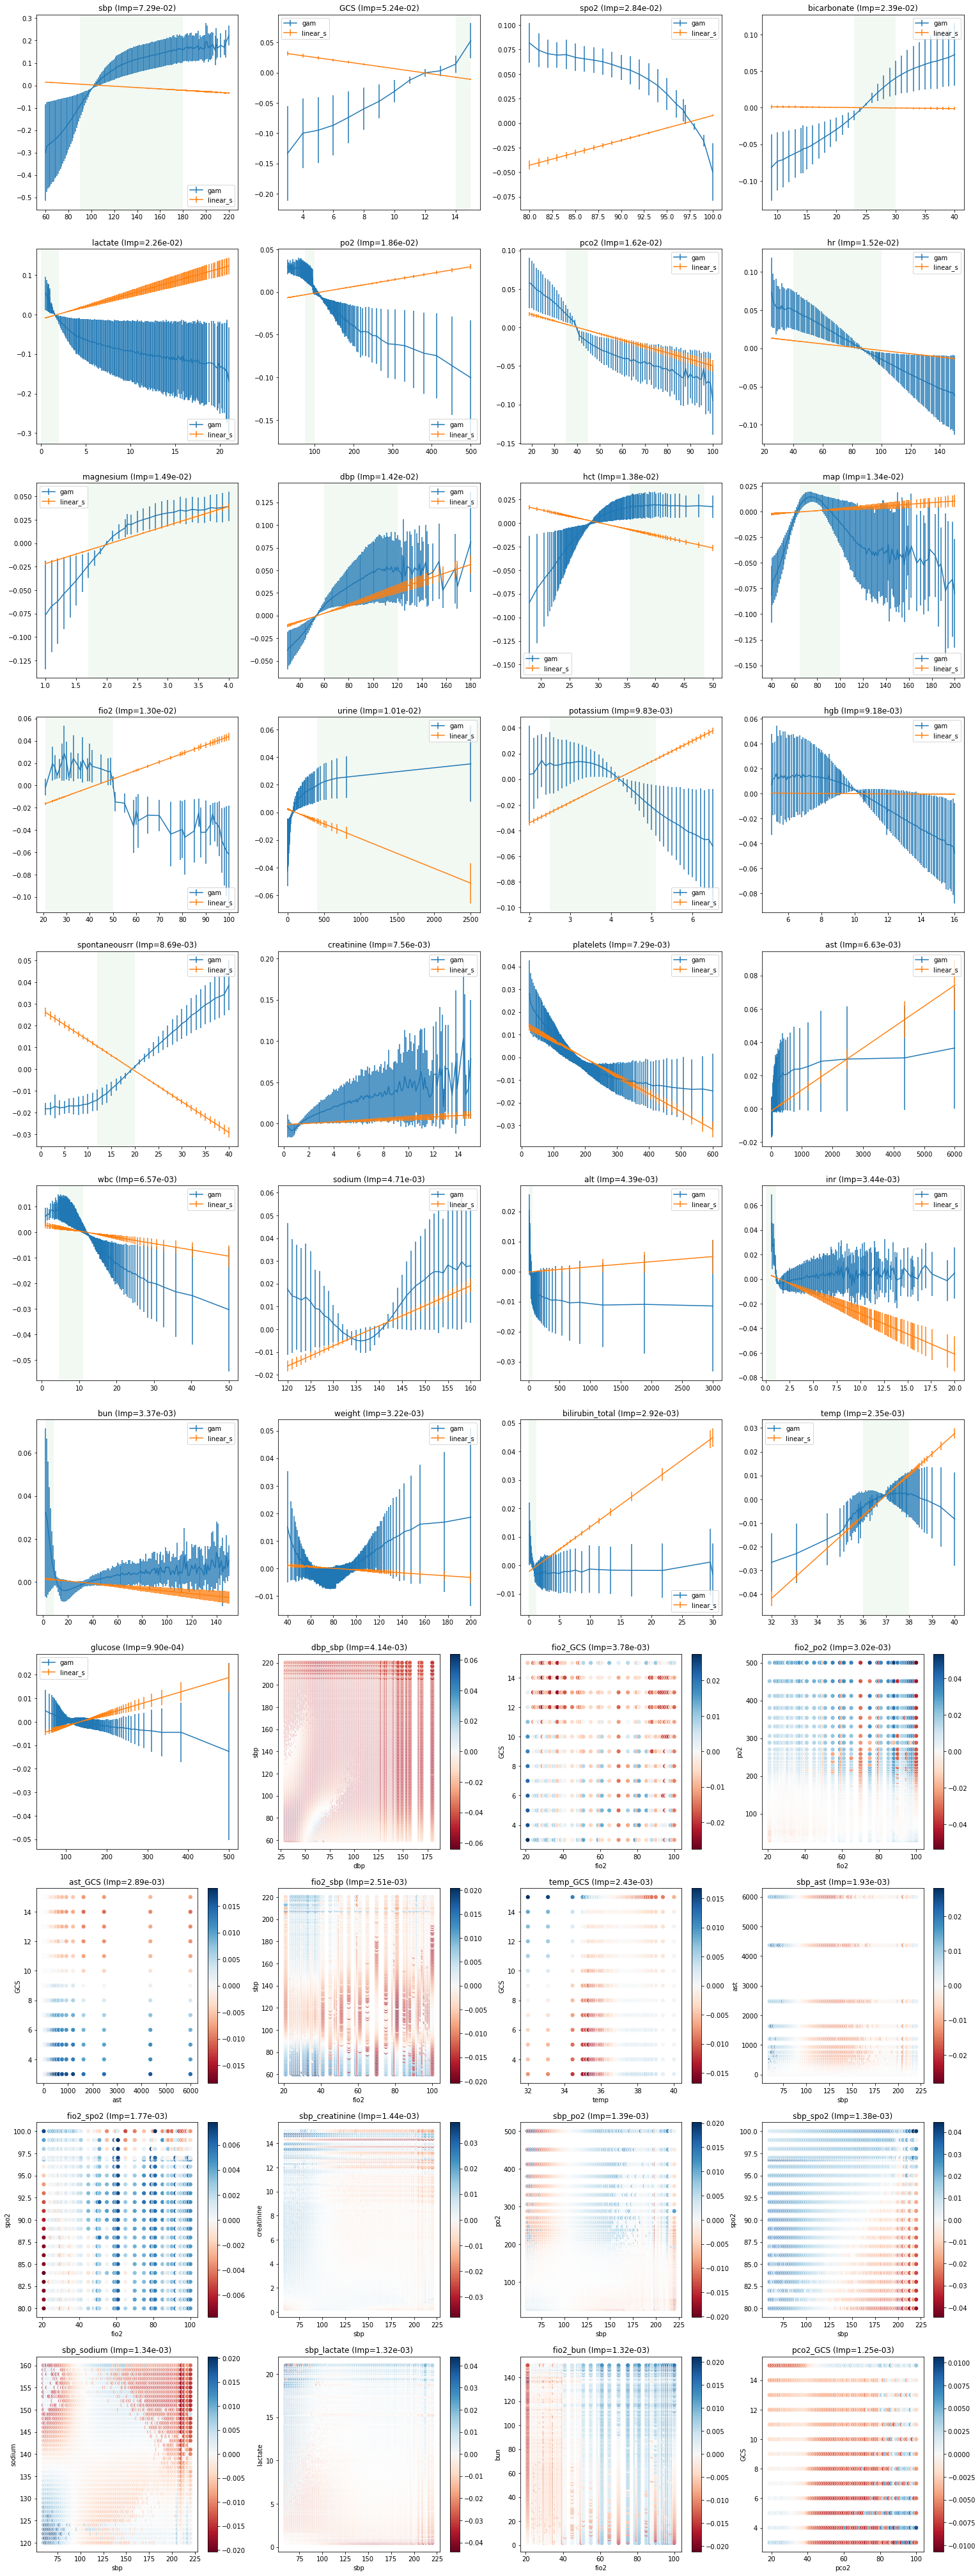

In [381]:
fig, ax = vis_main_effects(
    result1015_df, top_interactions=15, sort_by_imp=True, model_names=['gam', 'linear_s'],
    call_backs = {
        f: (lambda ax, f=f: add_patch(ax, f)) for f in normal_ranges
    },
)

#### Paper graph

sbp
GCS
bicarbonate
lactate
po2
pco2
map
fio2
wbc
temp
hr


/h/kingsley/irl_nodegam/lib/vis_utils.py:157: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)


urine
bilirubin_total
spontaneousrr
dbp
magnesium
hct
potassium
alt
inr
bun


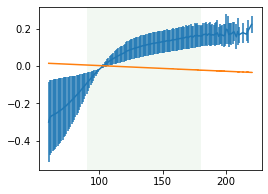

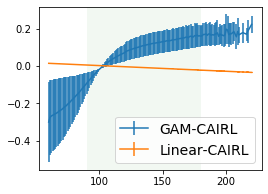

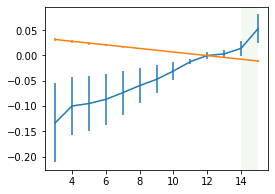

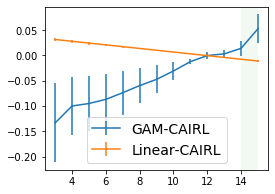

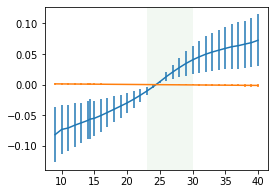

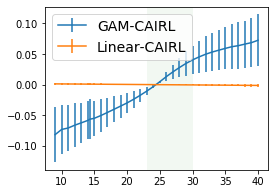

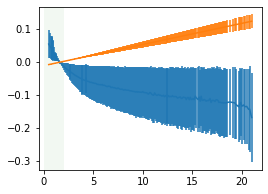

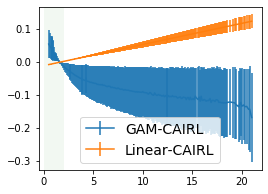

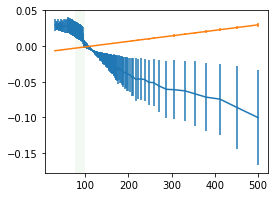

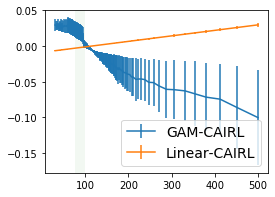

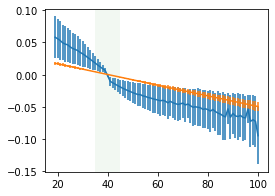

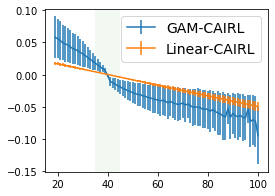

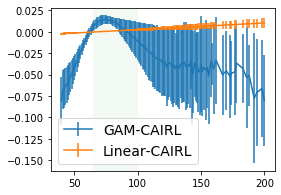

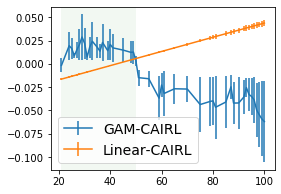

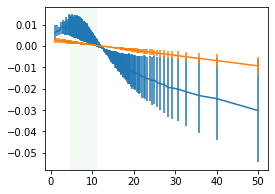

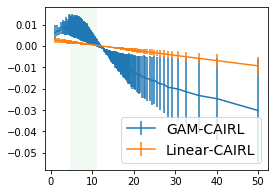

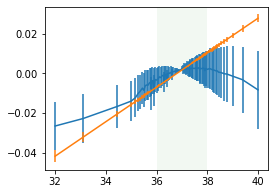

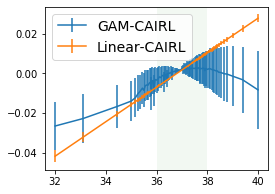

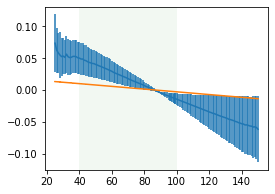

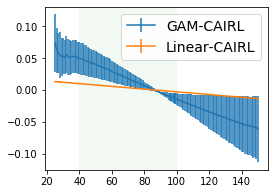

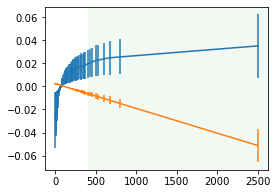

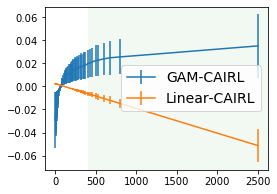

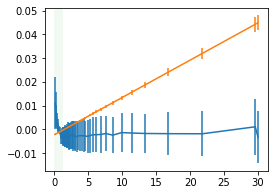

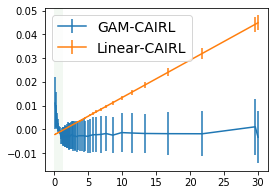

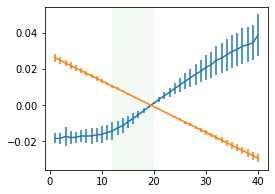

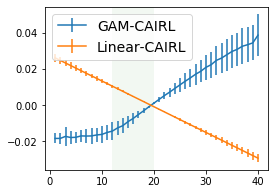

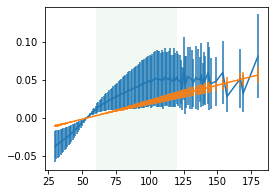

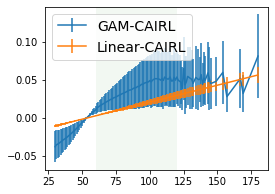

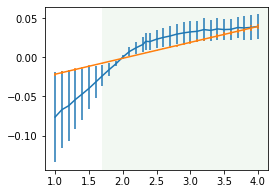

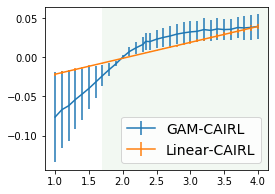

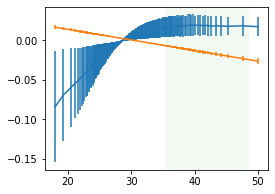

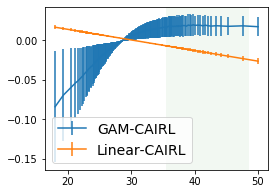

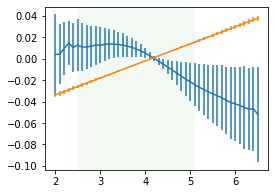

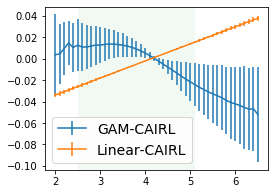

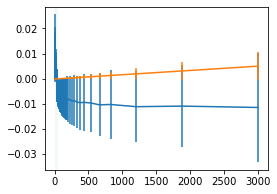

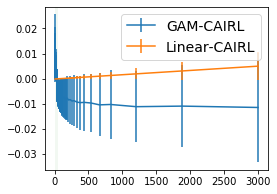

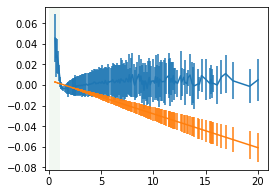

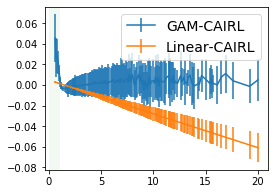

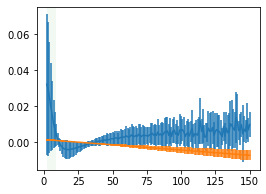

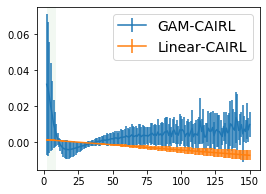

In [382]:
label_dict = {
    'gam': 'GAM-CAIRL',
    'linear_s': 'Linear-CAIRL',
}

for f in ['sbp', 'GCS', 'bicarbonate', 'lactate', 'po2', 'pco2', 'map', 'fio2', 'wbc', 'temp', 'hr', 'urine', 
          'bilirubin_total', 'spontaneousrr', 'dbp', 'magnesium', 'hct', 'potassium', 'alt', 'inr', 'bun']:
    print(f)
    for legend in ['_no_legend', '']:
        fig, ax = vis_main_effects(result1015_df, feature_names=[f], model_names=['gam', 'linear_s'], num_cols=1, figsize=(4, 3))

        # When plotting, we put the important ones last to overlay prev lines. Now legend shows the opposite
        handles, labels = ax.get_legend_handles_labels()

        font_size = 14
    #     if f == 'Na':
    #         font_size = 12
        ax.legend(handles, [label_dict[l] for l in labels], prop={'size': font_size})
        if legend == '_no_legend':
            ax.get_legend().remove()
        ax.set_title('')
        
        # Plot the pale color rectangular
        if f in normal_ranges:
            # Create a Rectangle patch
            x_min, x_max = normal_ranges[f]
            fig_x_min, fig_x_max = ax.get_xlim()
            if x_min < 0 or x_min < fig_x_min:
                x_min = fig_x_min
            if x_max < 0 or x_max > fig_x_max:
                x_max = fig_x_max
            y_min, y_max = ax.get_ylim()
            rect = patches.Rectangle((x_min, y_min), (x_max - x_min), (y_max - y_min), linewidth=0, edgecolor='none', facecolor='green', alpha=0.05)

            # Add the patch to the Axes
            ax.add_patch(rect)
        
#         plt.show()
        os.makedirs('./notebooks/figures/mimic3', exist_ok=True)
        fig.savefig(f'./notebooks/figures/mimic3/{f}{legend}.pdf', dpi=300, bbox_inches='tight')
#     break

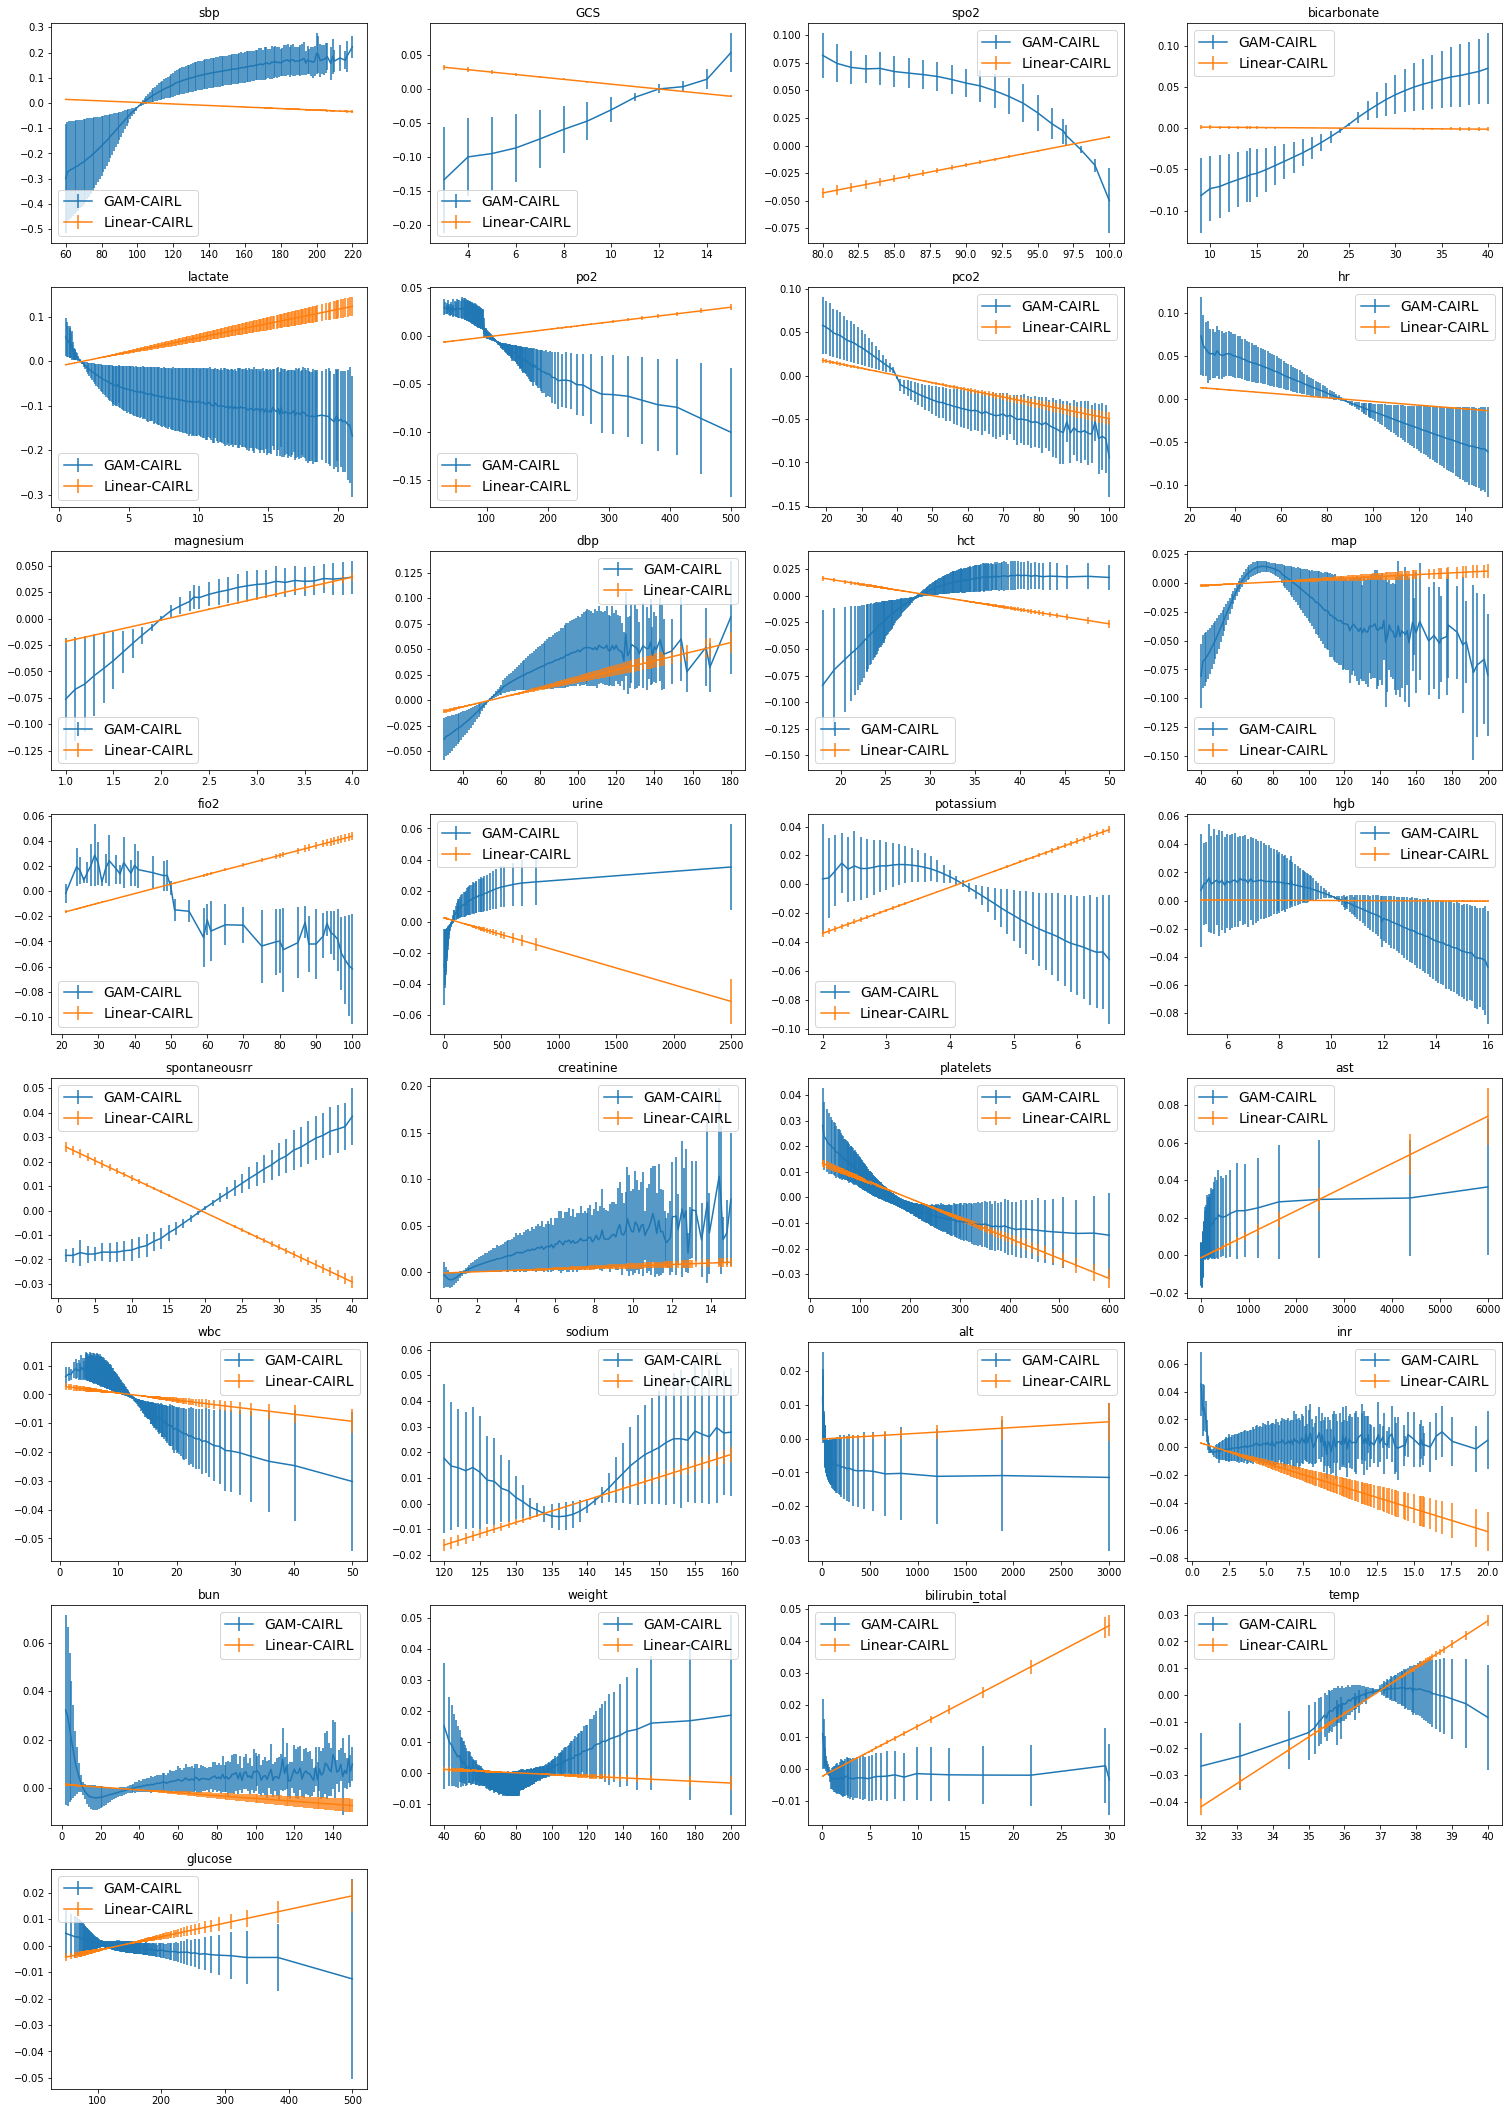

In [463]:
label_dict = {
    'gam': 'GAM-CAIRL',
    'linear_s': 'Linear-CAIRL',
}

fig, axes = vis_main_effects(
    result1015_df, top_interactions=0, sort_by_imp=True, model_names=['gam', 'linear_s'],
    vertical_margin=2, horizontal_margin=2, show_imp_in_title=False
#     call_backs = {
#         f: (lambda ax, f=f: add_patch(ax, f)) for f in normal_ranges
#     },
)

for ax in axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [label_dict[l] for l in labels], prop={'size': 14})

for ax in axes.flat[-3:]:
    ax.set_visible(False)

In [464]:
fig.savefig('notebooks/figures/mimic3/all.pdf', dpi=300, bbox_inches='tight')

### 1016 Linear best

In [265]:
dfs = get_dfs([
    f'1016_mimic3_best_f{fold}__linear_dlr0.001_aob0_ls0.005_fnl3_fdr0.5_glr0.0008_bca0.5_s192_dn0.0_dns0.8' for fold in range(5)
], all_X_mimic3)

rsync -avzL v:/h/kingsley/irl_nodegam/logs/hparams/1016_mimic3_best_f0__linear_dlr0.001_aob0_ls0.005_fnl3_fdr0.5_glr0.0008_bca0.5_s192_dn0.0_dns0.8 ./logs/hparams/
rsync -avzL v:/h/kingsley/irl_nodegam/logs/1016_mimic3_best_f0__linear_dlr0.001_aob0_ls0.005_fnl3_fdr0.5_glr0.0008_bca0.5_s192_dn0.0_dns0.8 ./logs/
rsync -avzL v:/h/kingsley/irl_nodegam/logs/hparams/1016_mimic3_best_f1__linear_dlr0.001_aob0_ls0.005_fnl3_fdr0.5_glr0.0008_bca0.5_s192_dn0.0_dns0.8 ./logs/hparams/
rsync -avzL v:/h/kingsley/irl_nodegam/logs/1016_mimic3_best_f1__linear_dlr0.001_aob0_ls0.005_fnl3_fdr0.5_glr0.0008_bca0.5_s192_dn0.0_dns0.8 ./logs/
rsync -avzL v:/h/kingsley/irl_nodegam/logs/hparams/1016_mimic3_best_f2__linear_dlr0.001_aob0_ls0.005_fnl3_fdr0.5_glr0.0008_bca0.5_s192_dn0.0_dns0.8 ./logs/hparams/
rsync -avzL v:/h/kingsley/irl_nodegam/logs/1016_mimic3_best_f2__linear_dlr0.001_aob0_ls0.005_fnl3_fdr0.5_glr0.0008_bca0.5_s192_dn0.0_dns0.8 ./logs/
rsync -avzL v:/h/kingsley/irl_nodegam/logs/hparams/1016_mimic3_b

In [266]:
avg_df = average_GAM_dfs(dfs)

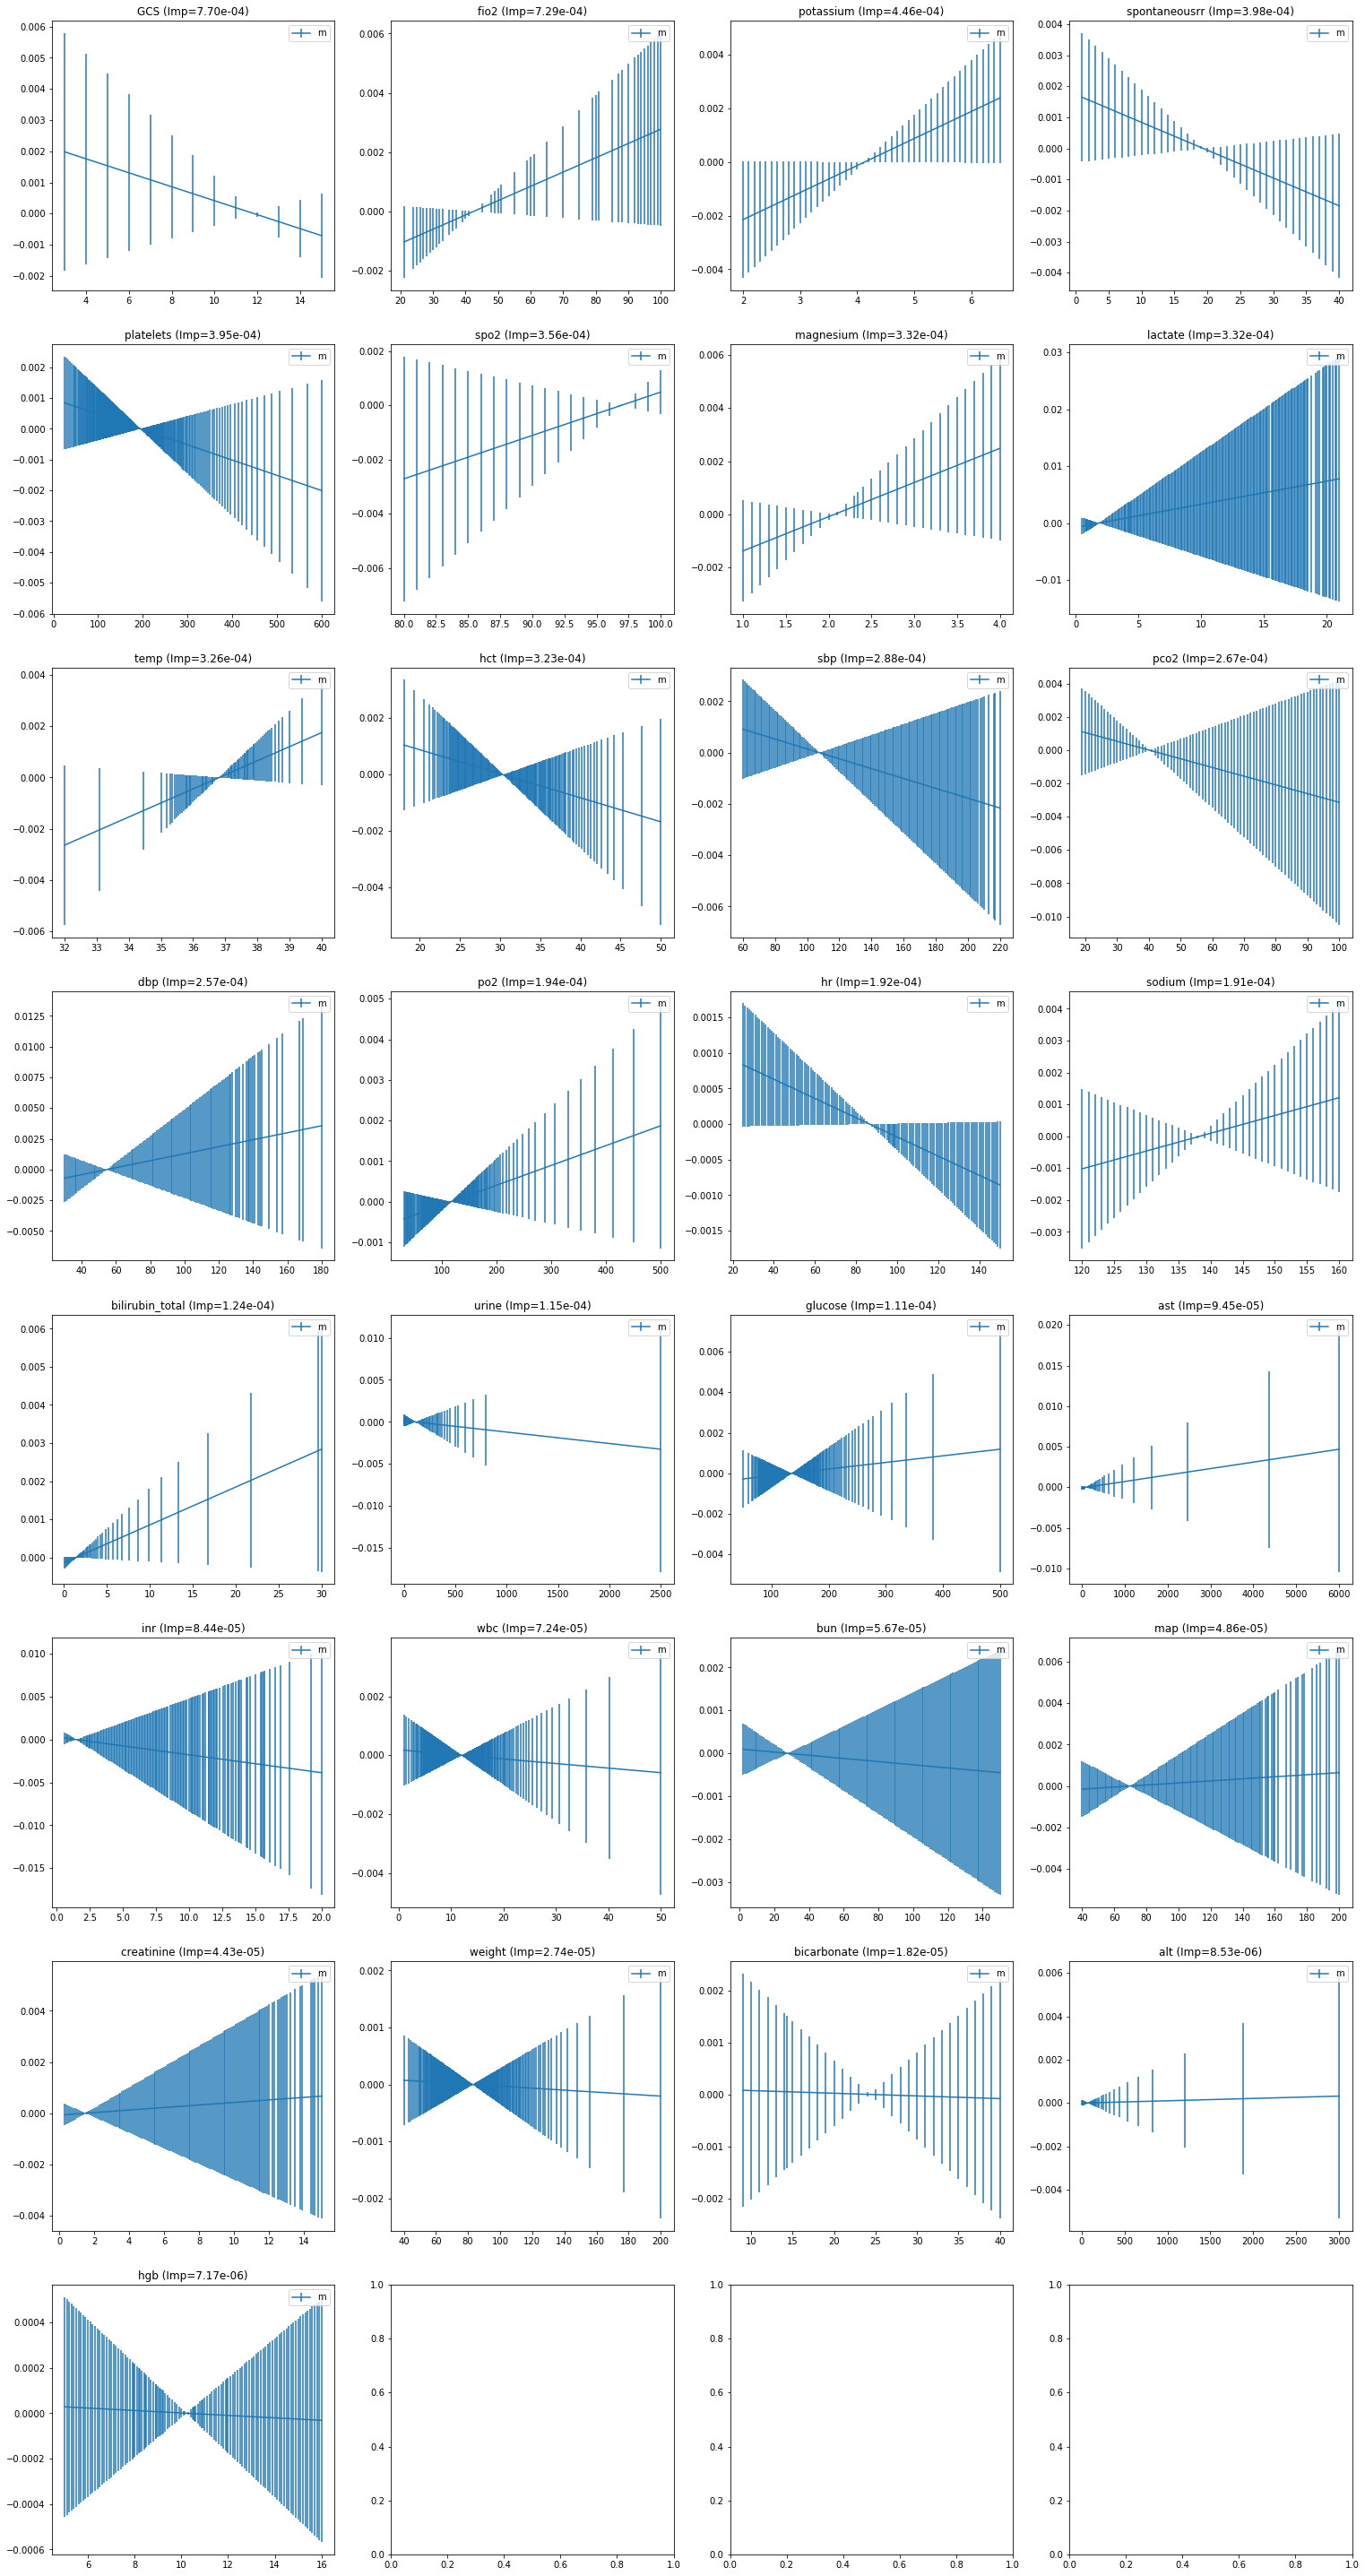

In [267]:
fig, ax = vis_main_effects({'m': avg_df}, top_interactions=15, sort_by_imp=True)

### 1017 GAM best (gamma=1)

In [291]:
dfs = get_dfs([
    f'1017_mimic3_best_f{fold}__gam_dlr0.0008_aob1_ls0.005_aGAM_nl3_nt200_ad0_td4_ld0.5_cs0.5_an3000_la0_ll1_od0.1_fnl3_fdr0.5_glr0.0008_bca0.5_s190_dn0.1_dns0.8' for fold in range(5)
], all_X_mimic3)

rsync -avzL v:/h/kingsley/irl_nodegam/logs/hparams/1017_mimic3_best_f0__gam_dlr0.0008_aob1_ls0.005_aGAM_nl3_nt200_ad0_td4_ld0.5_cs0.5_an3000_la0_ll1_od0.1_fnl3_fdr0.5_glr0.0008_bca0.5_s190_dn0.1_dns0.8 ./logs/hparams/
rsync -avzL v:/h/kingsley/irl_nodegam/logs/1017_mimic3_best_f0__gam_dlr0.0008_aob1_ls0.005_aGAM_nl3_nt200_ad0_td4_ld0.5_cs0.5_an3000_la0_ll1_od0.1_fnl3_fdr0.5_glr0.0008_bca0.5_s190_dn0.1_dns0.8 ./logs/


  2%|▏         | 6/278 [00:00<00:05, 53.27it/s]

Finish "Run values through model" in 41.6s


100%|██████████| 278/278 [00:07<00:00, 35.61it/s]


Finish "Extract values" in 7.9s


  0%|          | 0/282 [00:00<?, ?it/s]

Finish "Purify interactions to main effects" in 2.1s
Finish "Center main effects" in 6ms


100%|██████████| 282/282 [00:04<00:00, 66.02it/s]


Finish "Construct table" in 4.3s
rsync -avzL v:/h/kingsley/irl_nodegam/logs/hparams/1017_mimic3_best_f1__gam_dlr0.0008_aob1_ls0.005_aGAM_nl3_nt200_ad0_td4_ld0.5_cs0.5_an3000_la0_ll1_od0.1_fnl3_fdr0.5_glr0.0008_bca0.5_s190_dn0.1_dns0.8 ./logs/hparams/
rsync -avzL v:/h/kingsley/irl_nodegam/logs/1017_mimic3_best_f1__gam_dlr0.0008_aob1_ls0.005_aGAM_nl3_nt200_ad0_td4_ld0.5_cs0.5_an3000_la0_ll1_od0.1_fnl3_fdr0.5_glr0.0008_bca0.5_s190_dn0.1_dns0.8 ./logs/


  2%|▏         | 6/271 [00:00<00:05, 52.69it/s]

Finish "Run values through model" in 41.0s


100%|██████████| 271/271 [00:07<00:00, 35.20it/s]


Finish "Extract values" in 7.8s


  0%|          | 0/277 [00:00<?, ?it/s]

Finish "Purify interactions to main effects" in 1.9s
Finish "Center main effects" in 6ms


100%|██████████| 277/277 [00:04<00:00, 60.79it/s]


Finish "Construct table" in 4.6s
rsync -avzL v:/h/kingsley/irl_nodegam/logs/hparams/1017_mimic3_best_f2__gam_dlr0.0008_aob1_ls0.005_aGAM_nl3_nt200_ad0_td4_ld0.5_cs0.5_an3000_la0_ll1_od0.1_fnl3_fdr0.5_glr0.0008_bca0.5_s190_dn0.1_dns0.8 ./logs/hparams/
rsync -avzL v:/h/kingsley/irl_nodegam/logs/1017_mimic3_best_f2__gam_dlr0.0008_aob1_ls0.005_aGAM_nl3_nt200_ad0_td4_ld0.5_cs0.5_an3000_la0_ll1_od0.1_fnl3_fdr0.5_glr0.0008_bca0.5_s190_dn0.1_dns0.8 ./logs/


  2%|▏         | 6/271 [00:00<00:04, 53.35it/s]

Finish "Run values through model" in 41.0s


100%|██████████| 271/271 [00:07<00:00, 35.84it/s]


Finish "Extract values" in 7.6s


  0%|          | 0/276 [00:00<?, ?it/s]

Finish "Purify interactions to main effects" in 2.0s
Finish "Center main effects" in 6ms


100%|██████████| 276/276 [00:04<00:00, 58.09it/s]


Finish "Construct table" in 4.8s
rsync -avzL v:/h/kingsley/irl_nodegam/logs/hparams/1017_mimic3_best_f3__gam_dlr0.0008_aob1_ls0.005_aGAM_nl3_nt200_ad0_td4_ld0.5_cs0.5_an3000_la0_ll1_od0.1_fnl3_fdr0.5_glr0.0008_bca0.5_s190_dn0.1_dns0.8 ./logs/hparams/
rsync -avzL v:/h/kingsley/irl_nodegam/logs/1017_mimic3_best_f3__gam_dlr0.0008_aob1_ls0.005_aGAM_nl3_nt200_ad0_td4_ld0.5_cs0.5_an3000_la0_ll1_od0.1_fnl3_fdr0.5_glr0.0008_bca0.5_s190_dn0.1_dns0.8 ./logs/


  2%|▏         | 6/277 [00:00<00:05, 53.22it/s]

Finish "Run values through model" in 41.4s


100%|██████████| 277/277 [00:07<00:00, 35.72it/s]


Finish "Extract values" in 7.8s


 17%|█▋        | 49/281 [00:00<00:00, 472.74it/s]

Finish "Purify interactions to main effects" in 2.3s
Finish "Center main effects" in 6ms


100%|██████████| 281/281 [00:05<00:00, 54.73it/s]


Finish "Construct table" in 5.1s
rsync -avzL v:/h/kingsley/irl_nodegam/logs/hparams/1017_mimic3_best_f4__gam_dlr0.0008_aob1_ls0.005_aGAM_nl3_nt200_ad0_td4_ld0.5_cs0.5_an3000_la0_ll1_od0.1_fnl3_fdr0.5_glr0.0008_bca0.5_s190_dn0.1_dns0.8 ./logs/hparams/
rsync -avzL v:/h/kingsley/irl_nodegam/logs/1017_mimic3_best_f4__gam_dlr0.0008_aob1_ls0.005_aGAM_nl3_nt200_ad0_td4_ld0.5_cs0.5_an3000_la0_ll1_od0.1_fnl3_fdr0.5_glr0.0008_bca0.5_s190_dn0.1_dns0.8 ./logs/


  2%|▏         | 6/296 [00:00<00:05, 53.99it/s]

Finish "Run values through model" in 43.7s


100%|██████████| 296/296 [00:08<00:00, 35.61it/s]


Finish "Extract values" in 8.4s


 15%|█▌        | 45/300 [00:00<00:00, 442.70it/s]

Finish "Purify interactions to main effects" in 2.3s
Finish "Center main effects" in 6ms


100%|██████████| 300/300 [00:05<00:00, 55.18it/s]

Finish "Construct table" in 5.4s


In [292]:
avg_df = average_GAM_dfs(dfs)

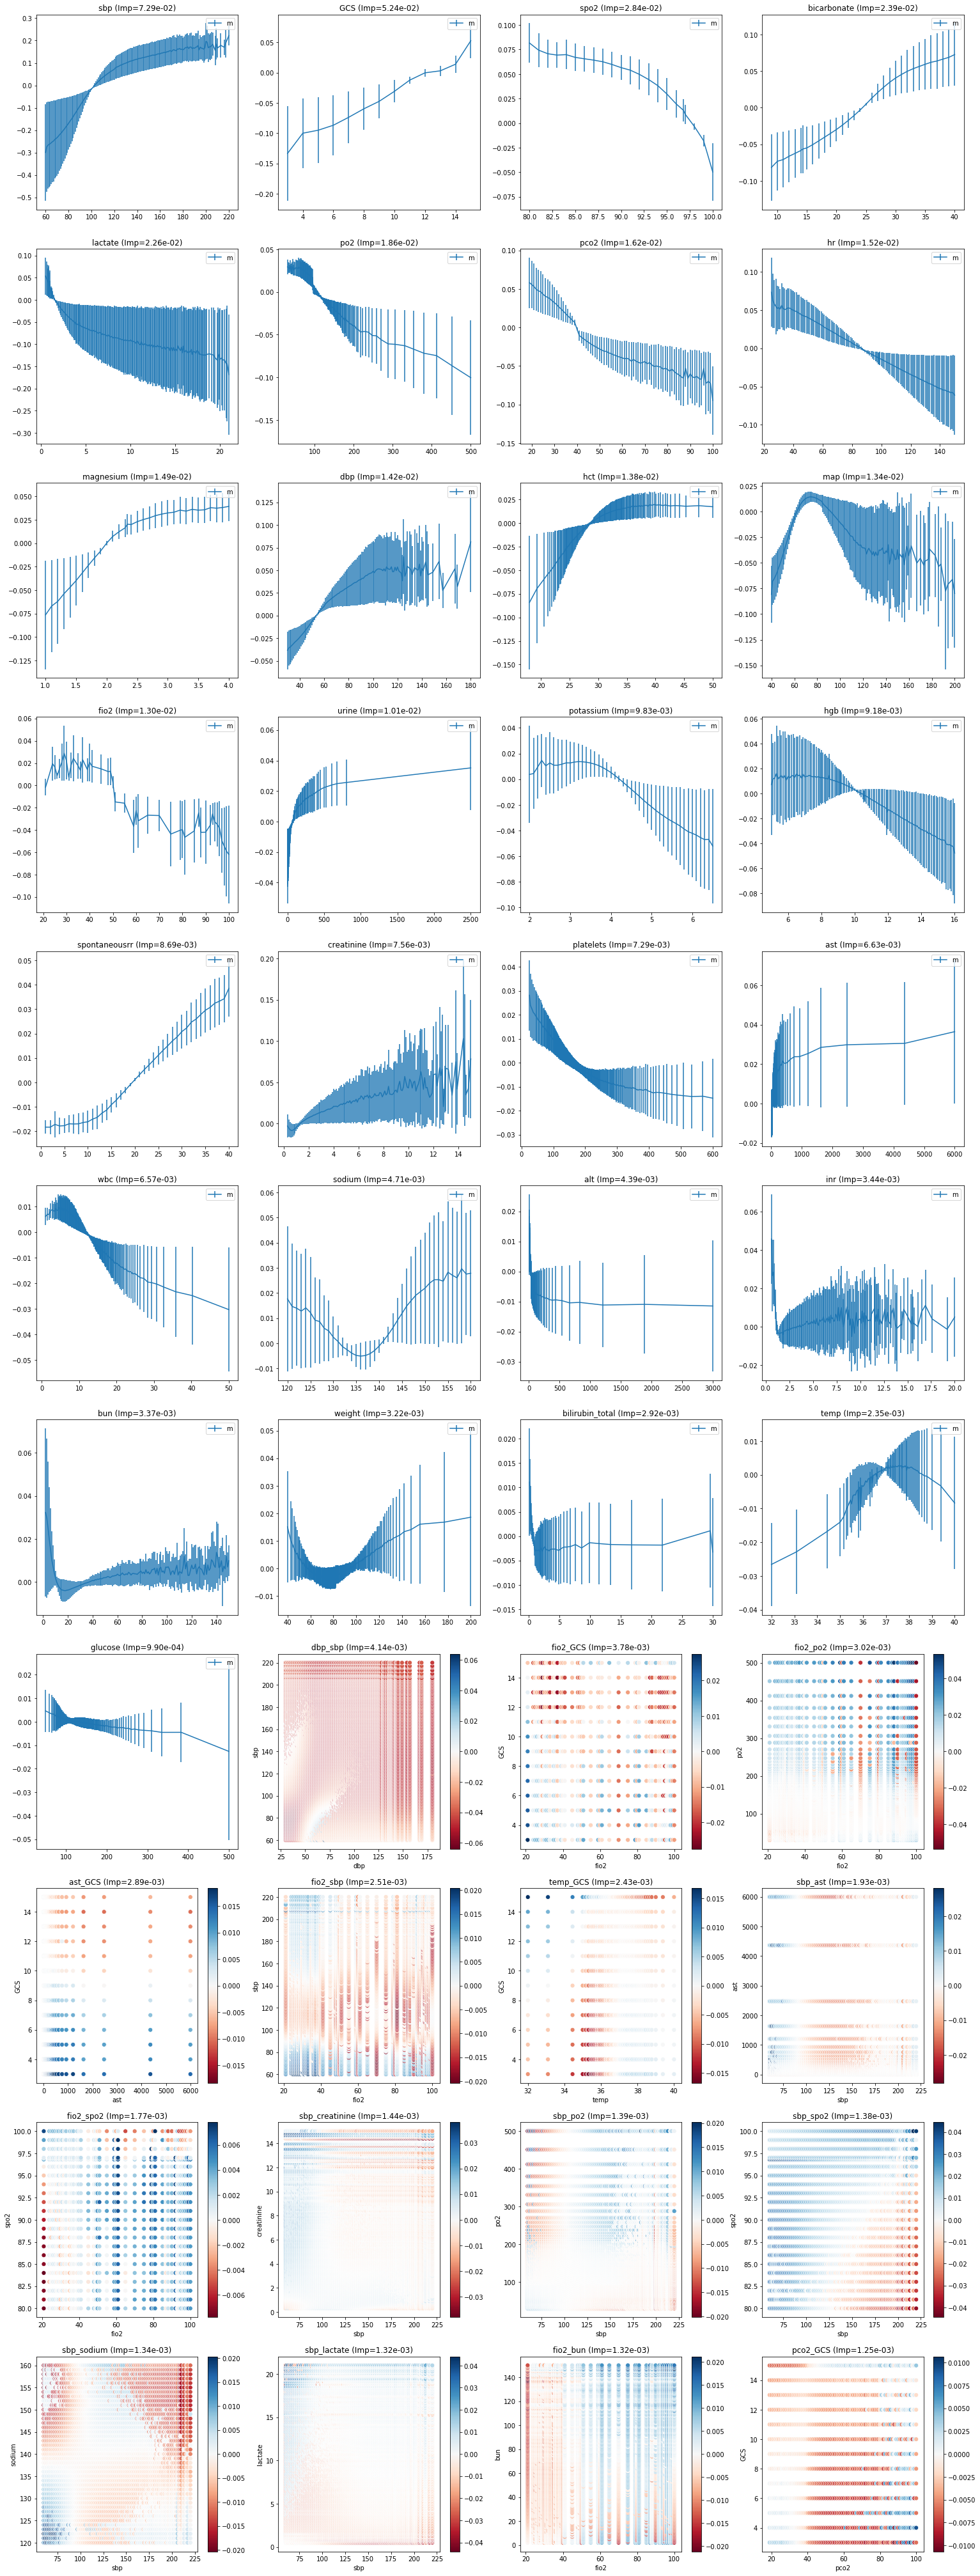

In [293]:
fig, ax = vis_main_effects({'m': avg_df}, top_interactions=15, sort_by_imp=True)